# Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 1. Prepare and merge the datasets

In [2]:
df_google_first = pd.read_csv('app_sdk/google_data_first.csv', encoding='ISO-8859-1')
df_google_first = df_google_first.loc[:, ~df_google_first.columns.str.contains('^Unnamed')]

In [3]:
df_google_last = pd.read_csv('app_sdk/google_data_last.csv', encoding='ISO-8859-1')
df_google_last = df_google_last.loc[:, ~df_google_last.columns.str.contains('^Unnamed')]

In [4]:
missing_rows = df_google_first[~df_google_first['my_app_id'].isin(df_google_last['my_app_id'])]

df = pd.concat([df_google_last, missing_rows], ignore_index=True)

# 2. Analyze dataframe

In [5]:
def dataframe_summary(df):
    print(f"DataFrame contains {df.shape[0]} rows and {df.shape[1]} columns.\n")
    df_info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Non-null Count': df.count(),
        'Null Count': df.isnull().sum(),
        'Null Percentage (%)': (df.isnull().sum() / len(df)) * 100
    })
    print(df_info)

# Run the function to get an enhanced summary of the DataFrame
dataframe_summary(df)

DataFrame contains 1016666 rows and 27 columns.

                    Data Type  Non-null Count  Null Count  Null Percentage (%)
my_app_id              object         1016666           0             0.000000
date_published         object         1016663           3             0.000295
privacy_policy         object          726139      290527            28.576445
rating_app            float64          927640       89026             8.756661
nb_rating              object          927639       89027             8.756760
num_downloads          object         1016651          15             0.001475
content_rating_app     object         1016663           3             0.000295
developer              object         1016658           8             0.000787
categ_app              object         1016658           8             0.000787
in_app                   bool         1016666           0             0.000000
has_ads                  bool         1016666           0             0.000000
pri

# 2. Preprocess DataFrame

In [6]:
# Use specific columns
df = df[['my_app_id', 'num_downloads', 'rating_app', 'nb_rating', 'price_gplay', 'in_app', 'content_rating_app', 'categ_app', 'date_published', 'has_ads', 'family_library', 'developer_name', 'developer_info']]
dataframe_summary(df)

DataFrame contains 1016666 rows and 13 columns.

                   Data Type  Non-null Count  Null Count  Null Percentage (%)
my_app_id             object         1016666           0             0.000000
num_downloads         object         1016651          15             0.001475
rating_app           float64          927640       89026             8.756661
nb_rating             object          927639       89027             8.756760
price_gplay           object         1012276        4390             0.431804
in_app                  bool         1016666           0             0.000000
content_rating_app    object         1016663           3             0.000295
categ_app             object         1016658           8             0.000787
date_published        object         1016663           3             0.000295
has_ads                 bool         1016666           0             0.000000
family_library          bool         1016666           0             0.000000
developer_name 

## 2.1 Classify Apps into Levels

### 2.1.1 Preprocess price_gplay to a numerical value.

Should be noted the app's prices have different currencies.

In [7]:
# Drop rows where no numeric part is found (if desired)
df = df.dropna(subset=['price_gplay'])

In [8]:
# List of currency symbols and codes to match, including €
currency_codes = ["€", "£", "$", "USD", "CZK", "EUR", "RUB", "AUD", "GBP", "JPY", "CAD", "KRW", "INR", "AED", 
                  "DKK", "SAR", "PLN", "UAH", "SEK", "IDR", "TRY", "TWD", "ILS", "HKD", "BGN", "MXN", "MYR", 
                  "BRL", "CLP", "CHF", ""]

# Create a regex pattern to match the symbols and codes
currency_pattern = r'|'.join(map(re.escape, currency_codes))

df_filtered = df.copy()

# Remove currency symbols and codes
df_filtered['price_value'] = df_filtered['price_gplay'].apply(lambda x: re.sub(currency_pattern, '', x).strip() if isinstance(x, str) else None)

df_filtered['price_value'] = df_filtered['price_value'].str.replace(',', '.')

# remove initial-scale=1. minimum-scale " hre
df_filtered['price_value'] = df_filtered['price_value'].str.replace('initial-scale=1. minimum-scale " hre', '')

# remove empty strings
df_filtered = df_filtered[df_filtered['price_value'] != '']

# convert to float
df_filtered['price_value'] = df_filtered['price_value'].astype(float)

# make new column with if app is free or not
df_filtered['is_free'] = df_filtered['price_value'].apply(lambda x: True if x == 0 else False)

### 2.1.2 Convert in_app and has_ads to boolean.

In [9]:
# convert in_app and has_ads to boolean
df_filtered['in_app'] = df_filtered['in_app'].astype(bool)
df_filtered['has_ads'] = df_filtered['has_ads'].astype(bool)

df_filtered = df_filtered.dropna()

### 2.1.3 Define the levels.

In [10]:
# Create a DataFrame to represent the levels and their criteria
data = {
    "Level": ["0", "1", "2 (Sample)", "2 (Premium)", "3", "4", "5"],
    "Description": [
        "Helemaal geen monetization",
        "Alleen ads",
        "2 verschillende versies: sample",
        "2 verschillende versies: premium",
        "Gratis met ads, en mogelijkheid voor extra features",
        "Gratis met in-app aankopen (geen ads)",
        "Betalen voor app-download (geen ads/in-app aankopen)"
    ],
    "Criteria": [
        "`is_free == 1`, `in_app == 0`, `has_ads == 0`",
        "`is_free == 1`, `in_app == 0`, `has_ads == 1`",
        "`is_free == 1`, `in_app == 0`, `has_ads ∈ [0, 1]`",
        "`is_free == 0`, `in_app == 0`, `has_ads == 0`",
        "`is_free == 1`, `in_app == 1`, `has_ads == 1`",
        "`is_free == 1`, `in_app == 1`, `has_ads == 0`",
        "`is_free == 0`, `in_app == 0`, `has_ads == 0`"
    ]
}

df_levels = pd.DataFrame(data)
df_levels

,Level,Description,Criteria
0,0,Helemaal geen monetization,"`is_free == 1`, `in_app == 0`, `has_ads == 0`"
1,1,Alleen ads,"`is_free == 1`, `in_app == 0`, `has_ads == 1`"
2,2 (Sample),2 verschillende versies: sample,"`is_free == 1`, `in_app == 0`, `has_ads ∈ [0, 1]`"
3,2 (Premium),2 verschillende versies: premium,"`is_free == 0`, `in_app == 0`, `has_ads == 0`"
4,3,"Gratis met ads, en mogelijkheid voor extra fea...","`is_free == 1`, `in_app == 1`, `has_ads == 1`"
5,4,Gratis met in-app aankopen (geen ads),"`is_free == 1`, `in_app == 1`, `has_ads == 0`"
6,5,Betalen voor app-download (geen ads/in-app aan...,"`is_free == 0`, `in_app == 0`, `has_ads == 0`"


In [11]:
# Level 0: Helemaal geen monetization
predicate_level_0 = (df_filtered['is_free'] == 1) & (df_filtered['in_app'] == 0) & (df_filtered['has_ads'] == 0)

# Level 1: Alleen ads
predicate_level_1 = (df_filtered['is_free'] == 1) & (df_filtered['in_app'] == 0) & (df_filtered['has_ads'] == 1)

# Level 2: 2 verschillende versies
predicate_level_2_sample = (df_filtered['is_free'] == 1) & (df_filtered['in_app'] == 0) & (df_filtered['has_ads'].isin([1, 0]))
predicate_level_2_premium = (df_filtered['is_free'] == 0) & (df_filtered['in_app'] == 0) & (df_filtered['has_ads'] == 0)

# Level 3: Gratis met ads, met de mogelijkheid om te betalen voor extra features of een app zonder ads
predicate_level_3 = (df_filtered['is_free'] == 1) & (df_filtered['in_app'] == 1) & (df_filtered['has_ads'] == 1)

# Level 4: Gratis, maar met in-app aankopen voor andere features
predicate_level_4 = (df_filtered['is_free'] == 1) & (df_filtered['in_app'] == 1) & (df_filtered['has_ads'] == 0)

# Level 5: Betalen voor het downloaden van de app, hetzelfde als in level 2 premium
predicate_level_5 = predicate_level_2_premium


# level 0 - Free
df_level_0 = df_filtered[predicate_level_0]

# level 1 - In-app advertising
df_level_1 = df_filtered[predicate_level_1]

# Level 2
# Possible sample apps: Free, with or without ads, without in-app purchases
df_level_2_sample = df_filtered[predicate_level_2_sample]

# Possible premium apps: Paid, without ads, with or without in-app purchases
df_level_2_premium = df_filtered[predicate_level_2_premium]


# level 3 - Free with ads and in-app purchases
df_level_3 = df_filtered[predicate_level_3]

# level 4 - Semi-premium (freemium)
df_level_4 = df_filtered[predicate_level_4]

# level 5 - Premium
df_level_5 = df_filtered[predicate_level_5]


### 2.1.4 Get level 2.

In [12]:
# Preprocess further on developer names. This says a developer must have at least 1 app in df_level_2_sample and df_level_2_premium. This makes sense since we want to find the sample and premium apps of the "same" app.

# Find common developer names
common_developers = pd.merge(
    df_level_2_sample[['developer_name']],
    df_level_2_premium[['developer_name']],
    on='developer_name',
    how='inner'
)['developer_name'].unique()

# Filter both DataFrames to keep only rows with common developers
df_level_2_sample_filtered = df_level_2_sample[
    df_level_2_sample['developer_name'].isin(common_developers)
]
df_level_2_premium_filtered = df_level_2_premium[
    df_level_2_premium['developer_name'].isin(common_developers)
]

#### 2.1.4.1 Word similarity algorithm.

In [13]:
# The app names are in the 'my_app_id' column. We will use these to find similar words between the two lists.
list1 = df_level_2_sample_filtered['my_app_id'].tolist()
list2 = df_level_2_premium_filtered['my_app_id'].tolist()

# Function to find similar words with at least 75% similarity
def find_similar_words(list1, list2, threshold=75):
    # Combine both lists for TF-IDF feature extraction
    combined_list = list1 + list2

    # Use TF-IDF Vectorizer to transform the text into feature vectors
    vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))  # You can change ngram_range for more efficiency
    tfidf_matrix = vectorizer.fit_transform(combined_list)

    # Separate the TF-IDF vectors for both lists
    tfidf_list1 = tfidf_matrix[:len(list1)]
    tfidf_list2 = tfidf_matrix[len(list1):]

    # Use NearestNeighbors for finding approximate matches
    # Set the number of neighbors to a minimum of 10 or the size of list2 to limit comparisons
    n_neighbors = min(10, len(list2))
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute', n_jobs=-1)
    nn.fit(tfidf_list2)

    similar_pairs = []
    distances, indices = nn.kneighbors(tfidf_list1)

    # Iterate through the results to find pairs with similarity above the threshold
    for i, (dists, idxs) in enumerate(zip(distances, indices)):
        for dist, idx in zip(dists, idxs):
            similarity = (1 - dist) * 100
            if similarity >= threshold:
                similar_pairs.append((list1[i], list2[idx], similarity))

    # Create a DataFrame from the similar pairs
    df = pd.DataFrame(similar_pairs, columns=['Sample app name', 'Premium app name', 'Similarity (%)'])
    return df

# Run the function on the slices
df_similarities = find_similar_words(list1, list2)

In [14]:
df_similarities.head()

,Sample app name,Premium app name,Similarity (%)
0,Andrew.Compass.com,andrew.compass.color2,85.780677
1,Andrew.Compass.com,andrew.compass.color3,85.317104
2,Andrew.Compass.com,andrew.compass.color1,84.718042
3,Andrew.Compass.com,andrew.compass.com.yellow,82.218412
4,AutoLoanCalculatorPRO.DPsoftware.org,AutoLoanCalculatorPRO_Market.DPsoftware.org,80.783936


#### 2.1.4.2 Extra filter (prefix).

In [15]:
# If the first word of the app names is the same, we can consider them as similar

# Fill NaN values with empty strings
df_similarities['First_Word_List1'] = df_similarities['Sample app name'].fillna('').str.split('.').str[0]
df_similarities['First_Word_List2'] = df_similarities['Premium app name'].fillna('').str.split('.').str[0]

# Perform case-insensitive comparison
df_similarities['Comparison_Result'] = df_similarities['First_Word_List1'] == df_similarities['First_Word_List2']

# Filter rows where the first words match
df_similarities = df_similarities[df_similarities['Comparison_Result'] == True]

# Drop the helper column if no longer needed
df_similarities = df_similarities.drop(columns=['Comparison_Result', 'First_Word_List1', 'First_Word_List2'])


#### 2.1.4.3 Filter extra on the difference.

In [16]:
def get_simple_suffix_difference(str1, str2):
    # Find the common prefix
    prefix_length = 0
    while prefix_length < len(str1) and prefix_length < len(str2) and str1[prefix_length] == str2[prefix_length]:
        prefix_length += 1

    # Extract the differing suffixes
    suffix1 = str1[prefix_length:]
    suffix2 = str2[prefix_length:]

    # Return the difference in suffixes
    return f"{suffix1.lower()}{suffix2.lower()}"

df_similarities['Difference Score'] = df_similarities.apply(
    lambda row: get_simple_suffix_difference(row['Sample app name'], row['Premium app name']),
    axis=1
)


In [17]:
df_similarities.tail()

,Sample app name,Premium app name,Similarity (%),Difference Score
22338,xyz.cryptomines.spacepools,xyz.cryptomines.SpacepoolsMonitor,87.178177,spacepoolsspacepoolsmonitor
22339,xyz.cryptomines.zpool,xyz.cryptomines.ZpoolMonitor,87.264442,zpoolzpoolmonitor
22340,xyz.digigem.gem.verge,xyz.digigem.gem.diamond,79.579567,vergediamond
22341,yukod.science.electronconfiglite,yukod.science.electronconfigengine,84.524221,liteengine
22342,yukod.science.electronconfiglite,yukod.science.electronconfiguration,83.404048,liteuration


In [18]:
# Get the tail of the second word (alphabetic characters only) that starts right after the first word
def get_tail_cleaned(first_app_name, second_app_name):
    """
    Returns the cleaned tail of the second app name (alphabetic characters only).
    that starts right after the first app name.
    """
    if first_app_name.startswith(second_app_name):
        tail = first_app_name[len(second_app_name):]
        # Remove non-alphabetic characters using regex
        return re.sub(r'[^a-zA-Z]', '', tail)
    return None

# Function to process a list of cleaned tails
def process_tails(df, col1, col2):
    """
    Extracts, cleans, and processes the tails between two columns in a DataFrame.
    Removes None and empty strings.
    """
    tails = df.apply(lambda row: get_tail_cleaned(row[col1], row[col2]), axis=1).dropna()
    return [x for x in tails if x]

# Process both sample and premium lists
sample_list = process_tails(df_similarities, 'Sample app name', 'Premium app name')
premium_list = process_tails(df_similarities, 'Premium app name', 'Sample app name')

# Count values that occur more than once
grouped_sample = pd.Series(sample_list).value_counts()
grouped_sample = grouped_sample[grouped_sample > 1]
grouped_premium = pd.Series(premium_list).value_counts()
grouped_premium = grouped_premium[grouped_premium > 1]

In [19]:
# List of indicative strings for free/sample and paid/premium versions. Inspired by grouped_sample and grouped_premium.
indicative_terms = [
    # Free/sample version terms
    "free",
    "lite",
    "demo",
    "trial",
    "beta",
    "ad",
    "light",
    "test",
    "eval",
    "preview",
    "gratis",
    "libre",
    "sample",
    "mini",
    "basic",
    "limited",
    "trail",
    "try",

    # Paid/premium version terms
    "pro",
    "full",
    "paid",
    "plus",
    "premium",
    "noads",
    "donate",
    "adfree",
    "key",
    "unlock",
    "license",
    "vip",
    "deluxe",
    "gold",
    "elite",
    "prime",
    "unlimited",
    "buy",
    "removeads"
]

In [20]:
# Filter the DataFrame to keep rows where 'Difference Score' contains any of the indicative terms
df_similarities = df_similarities[df_similarities['Difference Score'].str.contains('|'.join(indicative_terms), case=False, na=False)]

#### 2.1.4.4 Filter on level 2 sample apps and premium apps.

In [21]:
# Remove duplicate based on 'Sample app name' and 'Premium app name' columns
df_similarities = df_similarities.drop_duplicates(subset=['Sample app name'])
df_similarities = df_similarities.drop_duplicates(subset=['Premium app name'])

In [22]:
sample_app_names = df_similarities['Sample app name'].to_list()
premium_app_names = df_similarities['Premium app name'].to_list()

In [23]:
df_level_2_sample = df_level_2_sample_filtered[df_level_2_sample_filtered['my_app_id'].isin(sample_app_names)]
df_level_2_premium = df_level_2_premium_filtered[df_level_2_premium_filtered['my_app_id'].isin(premium_app_names)]

In [24]:
len(df_level_2_sample), len(df_level_2_premium)

(11432, 11432)

### 2.1.5 Filter apps from level 2 on level 0, 1 and 5.

In [25]:
# Filter on sample apps from level 2
df_level_0 = df_level_0[~df_level_0['my_app_id'].isin(df_level_2_sample['my_app_id'])]
df_level_1 = df_level_1[~df_level_1['my_app_id'].isin(df_level_2_sample['my_app_id'])]

# Filter on premium apps from level 2
df_level_5 = df_level_5[~df_level_5['my_app_id'].isin(df_level_2_premium['my_app_id'])]

### 2.1.6 Check that all levels have the right apps.

In [26]:
# Check for missing combinations by creating all unique combinations in the data
unique_combinations = df_filtered.groupby(['is_free', 'in_app', 'has_ads']).size()

# List of all covered combinations in levels
covered_combinations = pd.concat([
    df_level_0.groupby(['is_free', 'in_app', 'has_ads']).size(),
    df_level_1.groupby(['is_free', 'in_app', 'has_ads']).size(),
    df_level_2_sample.groupby(['is_free', 'in_app', 'has_ads']).size(),
    df_level_2_premium.groupby(['is_free', 'in_app', 'has_ads']).size(),
    df_level_3.groupby(['is_free', 'in_app', 'has_ads']).size(),
    df_level_4.groupby(['is_free', 'in_app', 'has_ads']).size(),
    df_level_5.groupby(['is_free', 'in_app', 'has_ads']).size()
])

# Identify combinations in the original data that are not covered by the levels
missing_combinations = unique_combinations[~unique_combinations.index.isin(covered_combinations.index)]

# Convert missing combinations to a DataFrame for easier readability
missing_combinations_df = missing_combinations.reset_index(name='count')
missing_combinations_df


,is_free,in_app,has_ads,count
0,False,False,True,3765
1,False,True,False,2481
2,False,True,True,532


In [27]:
data = {
    "is_free": [True, True, True, False, True, True, False],
    "in_app": [False, False, False, False, True, True, False],
    "has_ads": [False, True, [False, True], False, True, False, False],
    "level": ["0", "1", "2 (Sample)", "2 (Premium)", "3", "4", "5"]
}

df_levels = pd.DataFrame(data)
df_levels

,is_free,in_app,has_ads,level
0,True,False,False,0
1,True,False,True,1
2,True,False,"[False, True]",2 (Sample)
3,False,False,False,2 (Premium)
4,True,True,True,3
5,True,True,False,4
6,False,False,False,5


In [28]:
# print the length of each level
print(f"Level 0: {len(df_level_0)}")
print(f"Level 1: {len(df_level_1)}")
print(f"Level 2 sample: {len(df_level_2_sample)}")
print(f"Level 2 premium: {len(df_level_2_premium)}")
print(f"Level 3: {len(df_level_3)}")
print(f"Level 4: {len(df_level_4)}")
print(f"Level 5: {len(df_level_5)}")

len(df_filtered)

Level 0: 313633
Level 1: 432264
Level 2 sample: 11432
Level 2 premium: 11432
Level 3: 73753
Level 4: 26286
Level 5: 48136


923714

In [29]:
# Assuming the length of each level is stored in variables, calculate the sum of all levels
total_length_sum = (
    len(df_level_0)
    + len(df_level_1)
    + len(df_level_2_sample)
    + len(df_level_2_premium)
    + len(df_level_3)
    + len(df_level_4)
    + len(df_level_5)
)

# Print the total sum
print(f"Total sum of all levels: {total_length_sum}")

# print the sum of missed combinations
print(missing_combinations_df['count'].sum())

# Is the total sum of all levels equal to the length of the original DataFrame?
print(total_length_sum + missing_combinations_df['count'].sum() == len(df_filtered))

Total sum of all levels: 916936
6778
True


## 2.2 Number of Downloads

In [30]:
def convert_to_numeric(value):
    """
    Clean and convert a string value to a numeric value.

    Parameters:
    value (str): The value to clean and convert.

    Returns:
    int or float: The cleaned and converted numeric value, or NaN if invalid.
    """
    if pd.isna(value):
        return np.nan
    try:
        # Remove ',', '+', '>' and strip whitespace
        cleaned_value = value.replace(',', '').replace('+', '').replace('>', '').strip()
        return float(cleaned_value)
    except ValueError:
        return np.nan

def clean_and_convert_column(df, column_name):
    """
    Apply the conversion function to a specified column in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column.
    column_name (str): The name of the column to clean and convert.

    Returns:
    pd.DataFrame: A copy of the DataFrame with the column cleaned and converted.
    """
    df = df.copy()  # Avoid modifying the original DataFrame
    df[column_name] = df[column_name].apply(convert_to_numeric)
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    df[column_name] = df['num_downloads'].astype(int)
    return df

# List of DataFrames to process
dataframes = [
    "df_filtered", "df_level_0", "df_level_1", "df_level_2_sample", 
    "df_level_2_premium", "df_level_3", "df_level_4", "df_level_5"
]

# Apply the function to each DataFrame
for name in dataframes:
    globals()[name] = clean_and_convert_column(globals()[name], column_name="num_downloads")


## 2.3 Ratings

In [31]:
def calculate_bayesian_average(df, rating_col, num_ratings_col, prior_weight):
    """
    Calculate the Bayesian average rating for each app in the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    rating_col (str): The name of the column containing the app ratings.
    num_ratings_col (str): The name of the column containing the number of ratings.
    prior_weight (int): The prior weight (m), representing the number of ratings at which the global mean is considered reliable.

    Returns:
    pd.DataFrame: The DataFrame with a new column 'bayesian_average' added.
    """
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()

    # Ensure the rating and number of ratings columns are numeric
    df[num_ratings_col] = df[num_ratings_col].str.replace(',', '', regex=True)  # Remove commas
    df.loc[:, rating_col] = pd.to_numeric(df[rating_col], errors='coerce')
    df.loc[:, num_ratings_col] = pd.to_numeric(df[num_ratings_col], errors='coerce')
    
    # Calculate the global mean rating
    global_mean_rating = df[rating_col].mean()
    
    # Calculate the Bayesian average for each row
    df['bayesian_average'] = (
        (global_mean_rating * prior_weight + df[rating_col] * df[num_ratings_col]) / 
        (prior_weight + df[num_ratings_col])
    )
    
    return df

# Apply the function to each DataFrame
prior_weight = 50  # You can adjust this value as needed

dataframes = [
    "df_filtered", "df_level_0", "df_level_1", "df_level_2_sample", 
    "df_level_2_premium", "df_level_3", "df_level_4", "df_level_5"
]

for name in dataframes:
    globals()[name] = calculate_bayesian_average(
        globals()[name], 
        rating_col="rating_app", 
        num_ratings_col="nb_rating", 
        prior_weight=prior_weight
    )


## 2.4 Content Rating

In [32]:
def clean_content_rating(df, column_name="content_rating_app"):
    """
    Clean and standardize the content rating column of a DataFrame.

    - Extracts PEGI ratings (3, 7, 12, 16, 18) using regex.
    - Standardizes values containing 'not yet been rated' to 'not yet been rated'.
    - Handles missing or invalid values gracefully.

    Parameters:
    df (pd.DataFrame): The DataFrame to clean.
    column_name (str): The name of the column to clean.

    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """
    # Ensure the column exists and convert to string to handle NaN
    df = df.copy()  # Avoid modifying the original DataFrame
    if column_name in df.columns:
        df[column_name] = df[column_name].astype(str)

        # Extract PEGI ratings using regex
        df.loc[:, column_name] = df[column_name].str.extract(r'(PEGI (3|7|12|16|18))', expand=False)[0].fillna(df[column_name])

        # Standardize 'not yet been rated'
        df.loc[df[column_name].str.contains('not yet been rated', na=False), column_name] = 'not yet been rated'

    return df

# List of DataFrames to process
dataframes = [
    "df_filtered", "df_level_0", "df_level_1", "df_level_2_sample", 
    "df_level_2_premium", "df_level_3", "df_level_4", "df_level_5"
]

# Apply the function to each DataFrame
for name in dataframes:
    globals()[name] = clean_content_rating(globals()[name], column_name="content_rating_app")


# 3. Hypotheses

In [33]:
print(f"Level 0: {len(df_level_0)}")
print(f"Level 1: {len(df_level_1)}")
print(f"Level 2 sample: {len(df_level_2_sample)}")
print(f"Level 2 premium: {len(df_level_2_premium)}")
print(f"Level 3: {len(df_level_3)}")
print(f"Level 4: {len(df_level_4)}")
print(f"Level 5: {len(df_level_5)}")

Level 0: 313633
Level 1: 432264
Level 2 sample: 11432
Level 2 premium: 11432
Level 3: 73753
Level 4: 26286
Level 5: 48136


In [34]:
# add category to each level
df_level_0['level'] = '0'
df_level_1['level'] = '1'
df_level_2_sample['level'] = '2 (Sample)'
df_level_2_premium['level'] = '2 (Premium)'
df_level_3['level'] = '3'
df_level_4['level'] = '4'
df_level_5['level'] = '5'

# combine all levels
df_level_combined = pd.concat([df_level_0, df_level_1, df_level_2_sample, df_level_2_premium, df_level_3, df_level_4, df_level_5])

In [35]:
df_level_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 916936 entries, 14 to 1016643
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   my_app_id           916936 non-null  object 
 1   num_downloads       916936 non-null  int64  
 2   rating_app          916936 non-null  float64
 3   nb_rating           916936 non-null  object 
 4   price_gplay         916936 non-null  object 
 5   in_app              916936 non-null  bool   
 6   content_rating_app  916936 non-null  object 
 7   categ_app           916936 non-null  object 
 8   date_published      916936 non-null  object 
 9   has_ads             916936 non-null  bool   
 10  family_library      916936 non-null  bool   
 11  developer_name      916936 non-null  object 
 12  developer_info      916936 non-null  object 
 13  price_value         916936 non-null  float64
 14  is_free             916936 non-null  bool   
 15  bayesian_average    916936 non-null  

In [36]:
# write the dataframes to csv
df_level_combined.to_csv('./SBM Group Project/data/google_data_levels_combined.csv', index=False)
df_similarities.to_csv('./SBM Group Project/data/mapping_level_2.csv', index=False)

## 3.1 Popularity

* H1a: Apps that allow the user to have free access to all features (level 0 and 1) will have the highest amount of downloads overall. However, the ratings may fluctuate, as quality can vary for free-to-access apps.
* H1b: The apps with the most downloads will be level 1. Most social media platforms, which dominate our culture, tend to have this revenue stream (Djaruma et al. 2023).
* H1c: For apps that utilize a sample and a premium version of the same app (level 2), the free versions of an app will have more downloads than their paid-for counterpart. Most, if not all, users will download the free version first, and then might upgrade. This means there should be a disparity between the number of downloads between the apps, as is also demonstrated by Liu, Au, and Choi (2012).
* H1d: The most downloaded apps in the gaming category will likely fall under level 4. Many popular games use this type of “pay-to-win” mechanism (Nieborg 2016). Therefore, it would be expected this same pattern would arise from our data.

### 3.1.1 H1a

In [37]:
df_h1a = df_level_combined.copy()

# if level is 0 or 1 then new column category is 'Free apps'
df_h1a['category'] = ['Free all feature apps' if level in ['0', '1'] else 'Free/Paid not all feature apps' for level in df_h1a['level']]

In [38]:
# Calculate the sum of downloads for each category
total_downloads_h1a = df_h1a.groupby('category')['num_downloads'].sum().reset_index()

#### 3.1.1.1 Apps that allow the user to have free access to all features (level 0 and 1) will have the highest amount of downloads overall.

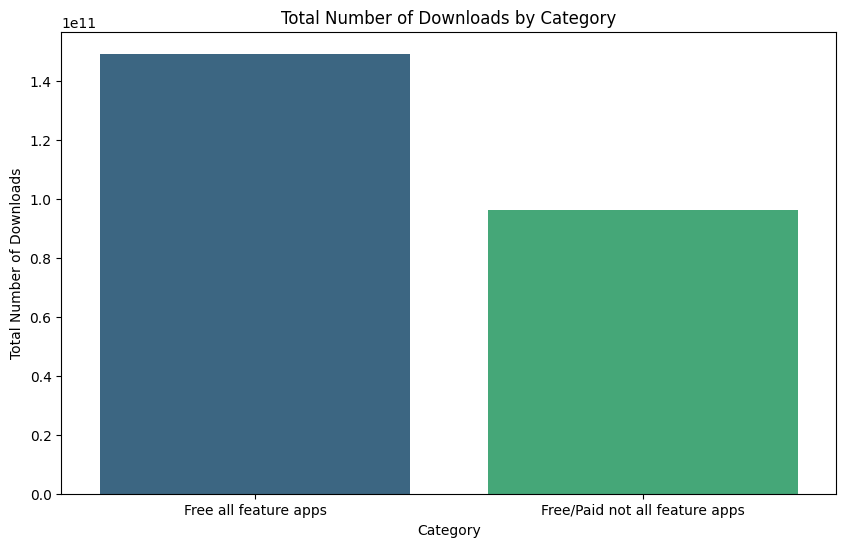

In [39]:
# Make a bar chart 
plt.figure(figsize=(10, 6))
sns.barplot(data=total_downloads_h1a, x='category', y='num_downloads', hue='category', palette='viridis', dodge=False)
plt.title('Total Number of Downloads by Category')
plt.xlabel('Category')
plt.ylabel('Total Number of Downloads')
plt.show()

#### 3.1.1.2 However, the ratings may fluctuate, as quality can vary for free-to-access apps.

In [40]:
# Calculate variance and standard deviation for each category
df_stats_h1a = df_h1a.groupby('category')['rating_app'].agg(['var', 'std']).reset_index()

# Rename columns for clarity
df_stats_h1a.rename(columns={'var': 'variance in rating', 'std': 'standard deviation in rating'}, inplace=True)

df_stats_h1a

,category,variance in rating,standard deviation in rating
0,Free all feature apps,0.531282,0.728891
1,Free/Paid not all feature apps,0.511318,0.715065


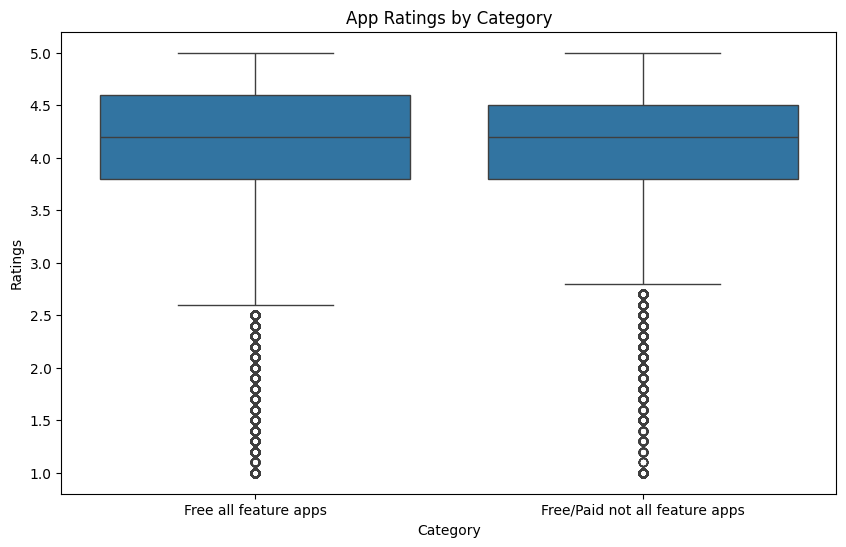

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_h1a, x='category', y='rating_app')
plt.title('App Ratings by Category')
plt.xlabel('Category')
plt.ylabel('Ratings')
plt.show()

C:\Users\Kevin\AppData\Local\Temp\ipykernel_20008\926861678.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=variance_data, x='category', y='rating_app', palette='viridis')


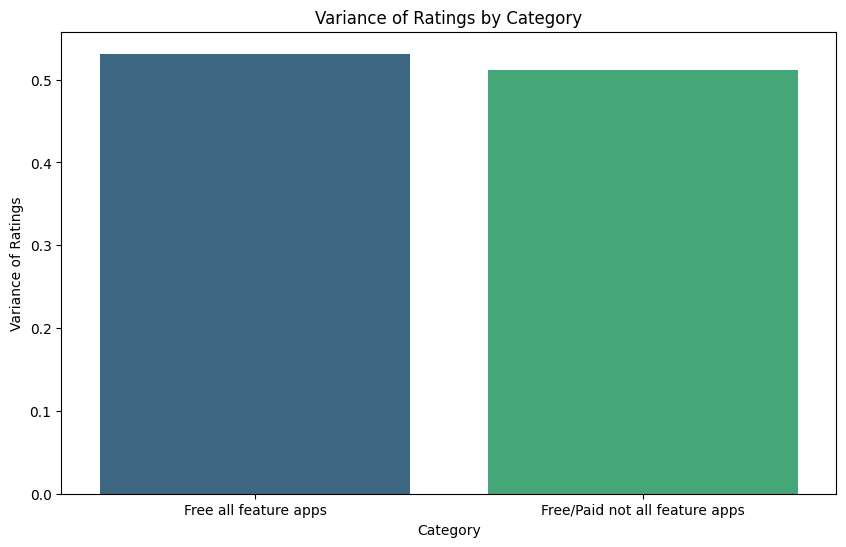

In [42]:
plt.figure(figsize=(10, 6))
variance_data = df_h1a.groupby('category')['rating_app'].var().reset_index()
sns.barplot(data=variance_data, x='category', y='rating_app', palette='viridis')
plt.title('Variance of Ratings by Category')
plt.xlabel('Category')
plt.ylabel('Variance of Ratings')
plt.show()

### 3.1.2 H1b

Our key findings reveal that 7 out of the top 9 apps fall within the freemium spectrum, enabling users to access their platforms freely but with certain “drawbacks.” This validation underscores that implementing the freemium model is the most effective strategy, regardless of the app category, due to its flexibility in attracting a substantial user base and generating significant revenue.
Among these freemium apps, it is evident that the network effect plays a crucial role, as seen in platforms like Instagram, TikTok, Snapchat, and Facebook, where the number of followers leads users to promote themselves and others through each platform.

In [43]:
df_h1b = df_level_combined.copy()

In [44]:
# convert float to int for num_downloads
df_h1b['num_downloads'] = df_h1b['num_downloads'].astype(int)

In [45]:
# relevant columns
relevant_columns_h1b = ['my_app_id', 'num_downloads', 'categ_app', 'level', 'developer_name']

# filter the relevant columns
df_h1b = df_h1b[relevant_columns_h1b]

In [46]:
# Calculate the sum of downloads for each level
total_downloads_h1b = df_h1b.groupby('level')['num_downloads'].sum().reset_index()

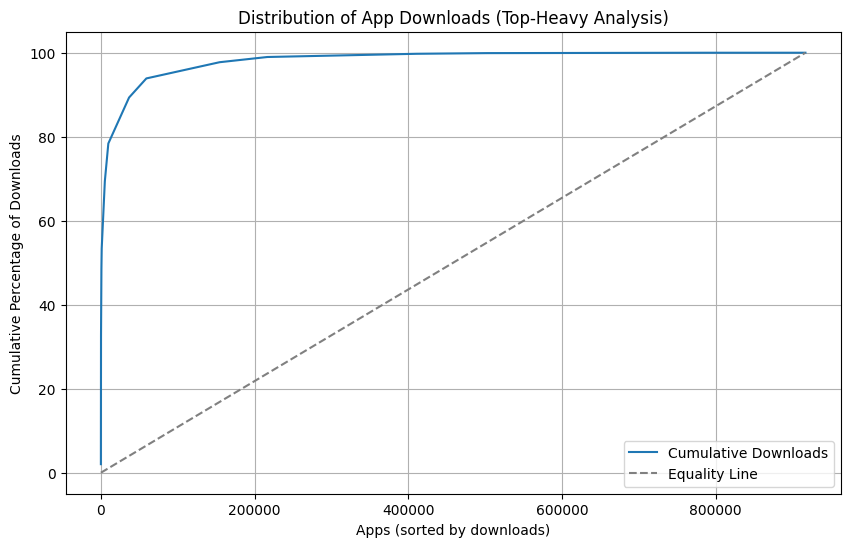

In [47]:
# Sort the dataframe by 'num_downloads' in descending order
df_sorted = df_h1b.sort_values(by='num_downloads', ascending=False)

# Calculate the cumulative percentage of downloads
df_sorted['cumulative_percentage_downloads'] = df_sorted['num_downloads'].cumsum() / df_sorted['num_downloads'].sum() * 100

# Create a Lorenz curve-style plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(df_sorted) + 1), df_sorted['cumulative_percentage_downloads'], label='Cumulative Downloads')
plt.plot([1, len(df_sorted)], [0, 100], linestyle='--', color='gray', label='Equality Line')

# Add labels and title
plt.title('Distribution of App Downloads (Top-Heavy Analysis)')
plt.xlabel('Apps (sorted by downloads)')
plt.ylabel('Cumulative Percentage of Downloads')
plt.legend()
plt.grid(True)
plt.show()

#### 3.1.2.1 The apps with the most downloads will be level 1.

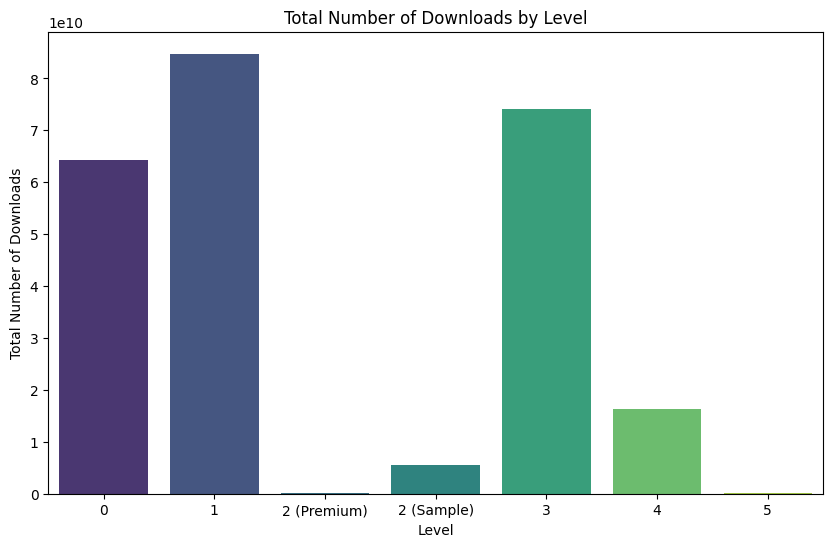

In [50]:
# Make a bar chart 
plt.figure(figsize=(10, 6))
sns.barplot(data=total_downloads_h1b, x='level', y='num_downloads', hue='level', palette='viridis', dodge=False)
plt.title('Total Number of Downloads by Level')
plt.xlabel('Level')
plt.ylabel('Total Number of Downloads')
plt.show()



#### 3.1.2.2 Most social media platforms, which dominate our culture, tend to have this revenue stream (Djaruma et al. 2023).

In [51]:
import pandas as pd

# Creating a DataFrame from the given table in the image
data = {
    "Name": ["Amazon", "Facebook", "Instagram", "Messenger", "Netflix", "Snapchat", "Spotify", "TikTok", "WhatsApp"],
    "Monetization Type": ["Freemium", "Freemium", "Freemium", "Freemium", "Premium", "Freemium", "Freemium", "Freemium", "Free"],
    "Detail": ["Ads, IAP", "Ads", "Ads", "Ads, IAP", "Subscription", "Ads", "Ads, Subscription", "Ads, IAP", "-"]
}

df = pd.DataFrame(data)
df


,Name,Monetization Type,Detail
0,Amazon,Freemium,"Ads, IAP"
1,Facebook,Freemium,Ads
2,Instagram,Freemium,Ads
3,Messenger,Freemium,"Ads, IAP"
4,Netflix,Premium,Subscription
5,Snapchat,Freemium,Ads
6,Spotify,Freemium,"Ads, Subscription"
7,TikTok,Freemium,"Ads, IAP"
8,WhatsApp,Free,-


In [52]:
df_h1b = df_h1b[df_h1b['my_app_id'].isin(['com.amazon.mShop.android.shopping', 'com.instagram.android', 'com.facebook.lite', 'com.netflix.mediaclient', 'com.snapchat.android', 'com.spotify.music', 'com.whatsapp', 'com.facebook.orca'])]

df_h1b = df_h1b[['my_app_id', 'num_downloads', 'categ_app', 'level']]

app_mapping = {
    'com.amazon.mShop.android.shopping': 'Amazon Shopping',
    'com.instagram.android': 'Instagram',
    'com.facebook.lite': 'Facebook Lite',
    'com.netflix.mediaclient': 'Netflix',
    'com.snapchat.android': 'Snapchat',
    'com.spotify.music': 'Spotify',
    'com.whatsapp': 'WhatsApp',
    'com.facebook.orca': 'Facebook Messenger'
}

# Map app names to the 'my_app_id' column
df_h1b['app_name'] = df_h1b['my_app_id'].map(app_mapping)

# Reorder columns for better readability
df_h1b = df_h1b[['my_app_id', 'app_name', 'num_downloads', 'categ_app', 'level']]


# Rename columns as per requirement
df_h1b = df_h1b.rename(columns={
    'my_app_id': 'id',
    'app_name': 'App Name',
    'num_downloads': 'Downloads (in B)',
    'level': 'Level',
    'categ_app': 'Category'
})

df_h1b

,id,App Name,Downloads (in B),Category,Level
631105,com.whatsapp,WhatsApp,1000000000,Communication,0
109761,com.amazon.mShop.android.shopping,Amazon Shopping,100000000,Shopping,1
264375,com.facebook.lite,Facebook Lite,1000000000,Social,1
340427,com.instagram.android,Instagram,1000000000,Social,1
548242,com.snapchat.android,Snapchat,500000000,Social,1
557054,com.spotify.music,Spotify,500000000,Music & Audio,1
264379,com.facebook.orca,Facebook Messenger,1000000000,Communication,4
449184,com.netflix.mediaclient,Netflix,500000000,Entertainment,4


In [56]:
# Top social apps by number of downloads
df_h1b[df_h1b['Category'] == 'Social'].sort_values(by='Downloads (in B)', ascending=False).head(10)

,id,App Name,Downloads (in B),Category,Level
264375,com.facebook.lite,Facebook Lite,1000000000,Social,1
340427,com.instagram.android,Instagram,1000000000,Social,1
548242,com.snapchat.android,Snapchat,500000000,Social,1


In [57]:
# Top communication apps by number of downloads
df_h1b[df_h1b['Category'] == 'Communication'].sort_values(by='Downloads (in B)', ascending=False).head(10)

,id,App Name,Downloads (in B),Category,Level
631105,com.whatsapp,WhatsApp,1000000000,Communication,0
264379,com.facebook.orca,Facebook Messenger,1000000000,Communication,4


### 3.1.3 H1c

In [58]:
df_sample_h1c = df_level_2_sample.copy()
df_premium_h1c = df_level_2_premium.copy()
df_mapping_h1c = df_similarities.copy()

In [59]:
# relevant columns
relevant_columns_h1c = ['my_app_id', 'num_downloads', 'level', 'rating_app']
relevant_columns_mapping_h1c =  ['Sample app name',	'Premium app name']

# filter the relevant columns
df_sample_h1c = df_sample_h1c[relevant_columns_h1c]
df_premium_h1c = df_premium_h1c[relevant_columns_h1c]
df_mapping_h1c = df_mapping_h1c[relevant_columns_mapping_h1c]

In [60]:
# Merge mapping dataframe with sample dataframe and premium dataframe
df_mapped_h1c = (
    df_mapping_h1c
    .merge(df_sample_h1c[['my_app_id', 'num_downloads', 'rating_app']], left_on='Sample app name', right_on='my_app_id', how='left')
    .drop(columns=['my_app_id'])
    .rename(columns={'num_downloads': 'Sample Downloads', 'rating_app': 'Sample Rating'})
    .merge(df_premium_h1c[['my_app_id', 'num_downloads', 'rating_app']], left_on='Premium app name', right_on='my_app_id', how='left')
    .drop(columns=['my_app_id'])
    .rename(columns={'num_downloads': 'Premium Downloads', 'rating_app': 'Premium Rating'})
)

In [61]:
# Calculate metrics
df_mapped_h1c['Download Difference'] = df_mapped_h1c['Premium Downloads'] - df_mapped_h1c['Sample Downloads']
df_mapped_h1c['Download Ratio'] = df_mapped_h1c['Premium Downloads'] / df_mapped_h1c['Sample Downloads']

# Data for the new dataframe
metric_data_h1c = {
    "Metric": [
        "Average Download Difference",
        "Average Download Ratio"
    ],
    "Value": [
        df_mapped_h1c['Download Difference'].mean(),
        df_mapped_h1c['Download Ratio'].mean(),
    ]
}

# Create the new dataframe
df_metrics_h1c = pd.DataFrame(metric_data_h1c)
df_metrics_h1c

,Metric,Value
0,Average Download Difference,-475145.245101
1,Average Download Ratio,0.265126


In [62]:
df_mapped_h1c.head()

,Sample app name,Premium app name,Sample Downloads,Sample Rating,Premium Downloads,Premium Rating,Download Difference,Download Ratio
0,HBSpritverbrauch.lite,HBSpritverbrauch.full,50000,4.4,5000,4.6,-45000,0.10
1,HBVerbrauchszaehler.lite,HBVerbrauchszaehler.full,50000,3.9,10000,4.6,-40000,0.20
2,Hurricane.Software,Hurricane.Software.Pro,500000,4.3,5000,4.0,-495000,0.01
3,JVC.FOViewerDX,JVC.FOViewerDXFull,10000,3.9,500,4.1,-9500,0.05
4,JVC.FOViewerDXHDTrial,JVC.FOViewerDXHD,1000,2.5,100,3.8,-900,0.10


#### 3.1.3.1 For apps that utilize a sample and a premium version of the same app (level 2), the free versions of an app will have more downloads than their paid-for counterpart.

In [63]:
# Calculating total sample and premium downloads
total_sample_downloads = df_mapped_h1c['Sample Downloads'].sum()
total_premium_downloads = df_mapped_h1c['Premium Downloads'].sum()

In [64]:
# Creating a new dataframe to represent the totals
summary_data_h1c = {
    "Version Type": ["Sample Downloads", "Premium Downloads"],
    "Total Downloads": [total_sample_downloads, total_premium_downloads]
}
df_summary_h1c = pd.DataFrame(summary_data_h1c)

In [65]:
df_summary_h1c.head()

,Version Type,Total Downloads
0,Sample Downloads,5491457990
1,Premium Downloads,59597548


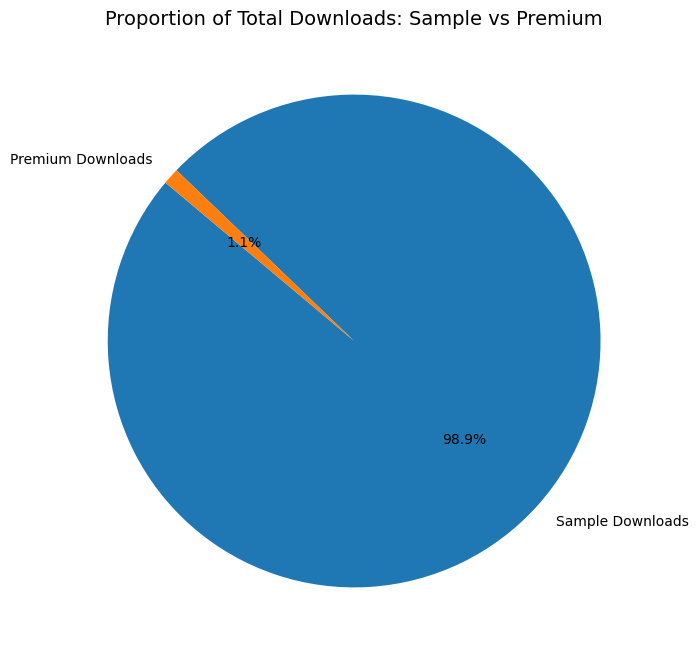

In [66]:
# Creating a pie chart to show the proportion of sample vs premium downloads
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(df_summary_h1c['Total Downloads'], labels=df_summary_h1c['Version Type'], autopct='%1.1f%%', startangle=140)
ax.set_title('Proportion of Total Downloads: Sample vs Premium', fontsize=14)

plt.show()

#### 3.1.3.2 Most, if not all, users will download the free version first, and then might upgrade. This means there should be a disparity between the number of downloads between the apps, as is also demonstrated by Liu, Au, and Choi (2012).

C:\Users\Kevin\AppData\Local\Temp\ipykernel_20008\2651317476.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_mapped_h1c['Sample Downloads'], df_mapped_h1c['Premium Downloads']], labels=['Sample Downloads', 'Premium Downloads'])


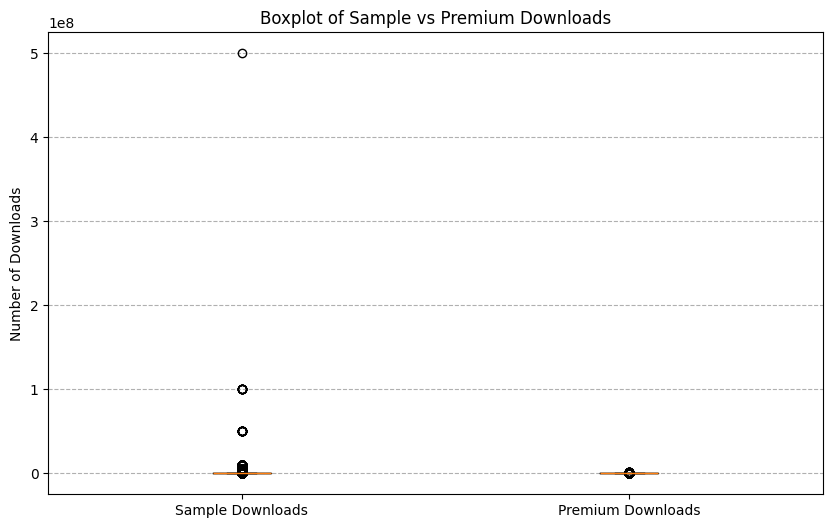

In [67]:
# Plot 4: Boxplot for Sample and Premium Downloads
plt.figure(figsize=(10, 6))
plt.boxplot([df_mapped_h1c['Sample Downloads'], df_mapped_h1c['Premium Downloads']], labels=['Sample Downloads', 'Premium Downloads'])
plt.ylabel('Number of Downloads')
plt.title('Boxplot of Sample vs Premium Downloads')
plt.grid(axis='y', linestyle='--')
plt.show()


In [68]:
# Data for the new dataframe
metric_data_h1c = {
    "Metric": [
        "Average Download Difference",
        "Average Download Ratio"
    ],
    "Value": [
        df_mapped_h1c['Download Difference'].mean(),
        df_mapped_h1c['Download Ratio'].mean(),
    ]
}

# Create the new dataframe
df_metrics_h1c = pd.DataFrame(metric_data_h1c)

In [69]:
df_metrics_h1c.head()

,Metric,Value
0,Average Download Difference,-475145.245101
1,Average Download Ratio,0.265126


### 3.1.4 H1d

In [70]:
df_level_combined_h1d = df_level_combined.copy()

In [71]:
# relevant columns
relevant_columns_h1d = ['my_app_id', 'num_downloads', 'level', 'categ_app']

# filter the relevant columns
df_level_combined_h1d = df_level_combined_h1d[relevant_columns_h1d]

In [72]:
df_level_combined_h1d.head()

,my_app_id,num_downloads,level,categ_app
14,Alfasoft.Widgets.PsychedelicAnalogClock,50000,0,Personalization
24,AmaxSoftware.bubblelevel,5000,0,Tools
25,Andrew.Compass.com,500000,0,Tools
26,Android.Page,100,0,Libraries & Demo
28,AndroidRoll.Roll,500,0,Casual


In [73]:
df_level_combined_h1d['categ_app'].value_counts()

categ_app
Education                  81630
Entertainment              60010
Personalization            56003
Tools                      51891
Lifestyle                  50749
Books & Reference          46506
Music & Audio              40727
Business                   40109
Travel & Local             30397
News & Magazines           27206
Photography                26348
Finance                    25010
Health & Fitness           24891
Productivity               24259
Sports                     23943
Shopping                   22354
Puzzle                     19617
Casual                     17622
Food & Drink               17608
Social                     17039
Maps & Navigation          16667
Communication              16369
Medical                    16225
Arcade                     15713
Simulation                 13579
Action                     10957
Auto & Vehicles             8380
Video Players & Editors     8260
Adventure                   8169
Trivia                      6776


In [74]:
# Creating a list of categories that can be considered as part of the gaming category
gaming_categories = [
    "Puzzle", "Casual", "Arcade", "Simulation", "Action", "Adventure", 
    "Trivia", "Racing", "Educational", "Card", "Word", "Board", 
    "Casino", "Role Playing", "Strategy", "Brain Games", 
    "Action & Adventure", "Pretend Play"
]

In [75]:
# Filter on games category
df_level_combined_h1d = df_level_combined_h1d[df_level_combined_h1d['categ_app'].isin(gaming_categories)]

#### 3.1.4.1 The most downloaded apps in the gaming category will likely fall under level 4 (and 3).

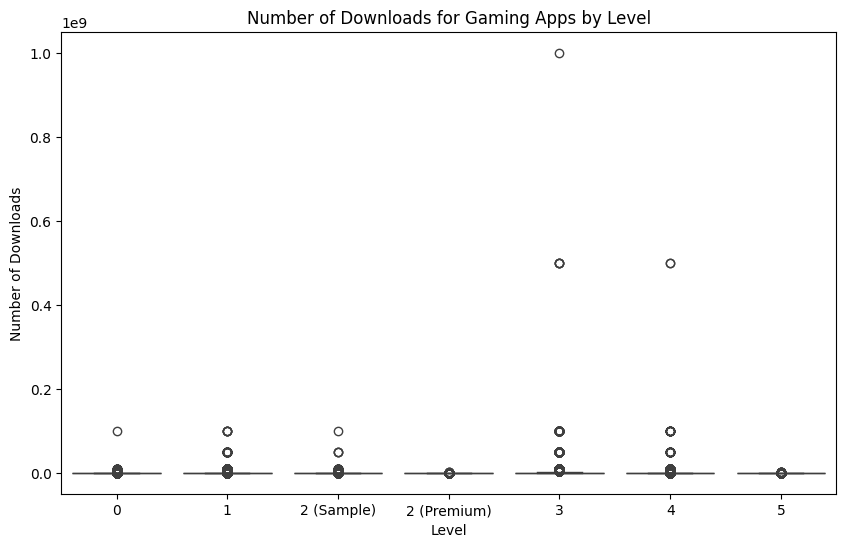

In [76]:
# boxplot the number of downloads for each level
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_level_combined_h1d, x='level', y='num_downloads')
plt.title('Number of Downloads for Gaming Apps by Level')
plt.xlabel('Level')
plt.ylabel('Number of Downloads')
plt.show()

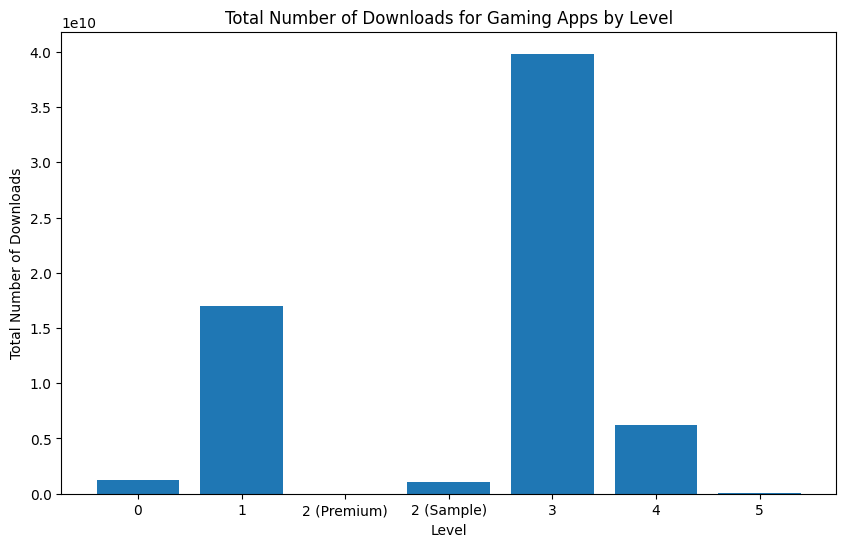

In [77]:
# Bar chart for total number of downloads per level
total_downloads_per_level = df_level_combined_h1d.groupby('level')['num_downloads'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(total_downloads_per_level['level'], total_downloads_per_level['num_downloads'])
plt.title('Total Number of Downloads for Gaming Apps by Level')
plt.xlabel('Level')
plt.ylabel('Total Number of Downloads')
plt.show()

Popular games like Subwaysurf, hillclimb and templerun 2 in level 3.

In [78]:
# Top 10 most downloaded apps in level 3
df_level_combined_h1d[df_level_combined_h1d['level'] == '3'].sort_values(by='num_downloads', ascending=False).head(10)

,my_app_id,num_downloads,level,categ_app
370724,com.kiloo.subwaysurf,1000000000,3,Arcade
270462,com.fingersoft.hillclimb,500000000,3,Racing
334291,com.imangi.templerun2,500000000,3,Action
470889,com.outfit7.mytalkingtomfree,500000000,3,Casual
747671,me.pou.app,500000000,3,Casual
233554,com.disney.wheresmywater2_goo,100000000,3,Puzzle
334290,com.imangi.templerun,100000000,3,Arcade
243591,com.dvloper.granny,100000000,3,Arcade
244462,com.ea.games.simsfreeplay_row,100000000,3,Simulation
204976,com.combineinc.streetracing.driftthreeD,100000000,3,Racing


Popular games like candy crush and clash of clans are in level 4.

In [79]:
# Top 10 most downloaded apps in level 4
df_level_combined_h1d[df_level_combined_h1d['level'] == '4'].sort_values(by='num_downloads', ascending=False).head(10)

,my_app_id,num_downloads,level,categ_app
371006,com.king.candycrushsaga,500000000,4,Casual
566815,com.supercell.clashofclans,500000000,4,Strategy
371038,com.king.petrescuesaga,100000000,4,Casual
371012,com.king.farmheroessaga,100000000,4,Casual
371007,com.king.candycrushsodasaga,100000000,4,Casual
411823,com.mediocre.smashhit,100000000,4,Arcade
244452,com.ea.game.simpsons4_row,100000000,4,Casual
581171,com.tencent.ig,100000000,4,Action
455201,com.nintendo.zara,100000000,4,Action
242228,com.dts.freefireth,100000000,4,Action


In [80]:
df_level_combined_h1d[df_level_combined_h1d['level'] == '4'] \
    .sort_values(by='num_downloads', ascending=False) \
    .head(5)

,my_app_id,num_downloads,level,categ_app
371006,com.king.candycrushsaga,500000000,4,Casual
566815,com.supercell.clashofclans,500000000,4,Strategy
371038,com.king.petrescuesaga,100000000,4,Casual
371012,com.king.farmheroessaga,100000000,4,Casual
371007,com.king.candycrushsodasaga,100000000,4,Casual


In [81]:
# Filter for level 3, sort by downloads, and pick top 10
top_apps = df_level_combined_h1d[df_level_combined_h1d['level'] == '4'] \
    .sort_values(by='num_downloads', ascending=False) \
    .head(5)
    
app_name_mapping = {
    "com.kiloo.subwaysurf": "Subway Surfers",
    "com.fingersoft.hillclimb": "Hill Climb Racing",
    "com.imangi.templerun2": "Temple Run 2",
    "com.outfit7.mytalkingtomfree": "My Talking Tom",
    "me.pou.app": "Pou"
}

# Convert num_downloads to per billion
top_apps['num_downloads'] = top_apps['num_downloads'] / 1_000_000_000

# Mapping the app column to their normal names
top_apps['App'] = top_apps['my_app_id'].map(app_name_mapping)

# Rename columns as per requirement
top_apps = top_apps.rename(columns={
    'my_app_id': 'id',
    'num_downloads': 'Downloads (in Billions)',
    'categ_app': 'Gaming Category'
})

top_apps.reset_index(drop=True, inplace=True)

# order the columns
top_apps = top_apps[['id', 'App', 'Downloads (in Billions)', 'Gaming Category']]

top_apps

,id,App,Downloads (in Billions),Gaming Category
0,com.king.candycrushsaga,NaN,0.5,Casual
1,com.supercell.clashofclans,NaN,0.5,Strategy
2,com.king.petrescuesaga,NaN,0.1,Casual
3,com.king.farmheroessaga,NaN,0.1,Casual
4,com.king.candycrushsodasaga,NaN,0.1,Casual


In [82]:
# Filter for level 3, sort by downloads, and pick top 5
top_apps_level_3 = df_level_combined_h1d[df_level_combined_h1d['level'] == '3'] \
    .sort_values(by='num_downloads', ascending=False) \
    .head(5)

app_name_mapping = {
    "com.kiloo.subwaysurf": "Subway Surfers",
    "com.fingersoft.hillclimb": "Hill Climb Racing",
    "com.imangi.templerun2": "Temple Run 2",
    "com.outfit7.mytalkingtomfree": "My Talking Tom",
    "me.pou.app": "Pou"
}

# Convert num_downloads to per billion
top_apps_level_3['num_downloads'] = top_apps_level_3['num_downloads'] / 1_000_000_000

# Mapping the app column to their normal names
top_apps_level_3['App'] = top_apps_level_3['my_app_id'].map(app_name_mapping)

# Rename columns as per requirement
top_apps_level_3 = top_apps_level_3.rename(columns={
    'my_app_id': 'id',
    'num_downloads': 'Downloads (in Billions)',
    'categ_app': 'Gaming Category'
})

top_apps_level_3.reset_index(drop=True, inplace=True)
top_apps_level_3 = top_apps_level_3[['id', 'App', 'Downloads (in Billions)', 'Gaming Category', 'level']]

# Filter for level 4, sort by downloads, and pick top 5
top_apps_level_4 = df_level_combined_h1d[df_level_combined_h1d['level'] == '4'] \
    .sort_values(by='num_downloads', ascending=False) \
    .head(5)

additional_app_name_mapping = {
    "com.king.candycrushsaga": "Candy Crush Saga",
    "com.supercell.clashofclans": "Clash of Clans",
    "com.king.petrescuesaga": "Pet Rescue Saga",
    "com.king.farmheroessaga": "Farm Heroes Saga",
    "com.king.candycrushsodasaga": "Candy Crush Soda Saga"
}

# Convert num_downloads to per billion
top_apps_level_4['num_downloads'] = top_apps_level_4['num_downloads'] / 1_000_000_000

# Mapping the app column to their normal names
top_apps_level_4['App'] = top_apps_level_4['my_app_id'].map(additional_app_name_mapping)

# Rename columns as per requirement
top_apps_level_4 = top_apps_level_4.rename(columns={
    'my_app_id': 'id',
    'num_downloads': 'Downloads (in Billions)',
    'categ_app': 'Gaming Category'
})

top_apps_level_4.reset_index(drop=True, inplace=True)
top_apps_level_4 = top_apps_level_4[['id', 'App', 'Downloads (in Billions)', 'Gaming Category', 'level']]

# Combine the tables
combined_tables = pd.concat([top_apps_level_3, top_apps_level_4])
combined_tables.sort_values(by='Downloads (in Billions)', ascending=False, inplace=True)
combined_tables

,id,App,Downloads (in Billions),Gaming Category,level
0,com.kiloo.subwaysurf,Subway Surfers,1.0,Arcade,3
1,com.fingersoft.hillclimb,Hill Climb Racing,0.5,Racing,3
2,com.imangi.templerun2,Temple Run 2,0.5,Action,3
3,com.outfit7.mytalkingtomfree,My Talking Tom,0.5,Casual,3
4,me.pou.app,Pou,0.5,Casual,3
0,com.king.candycrushsaga,Candy Crush Saga,0.5,Casual,4
1,com.supercell.clashofclans,Clash of Clans,0.5,Strategy,4
2,com.king.petrescuesaga,Pet Rescue Saga,0.1,Casual,4
3,com.king.farmheroessaga,Farm Heroes Saga,0.1,Casual,4
4,com.king.candycrushsodasaga,Candy Crush Soda Saga,0.1,Casual,4


### 3.1.5 Other Results

#### 3.1.5.1 Across Levels

In [83]:
downloads_across_level = df_level_combined.copy()

C:\Users\Kevin\AppData\Local\Temp\ipykernel_20008\1655852616.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=billion_downloads_summary, x='Category', y='Number of Apps', palette='viridis')


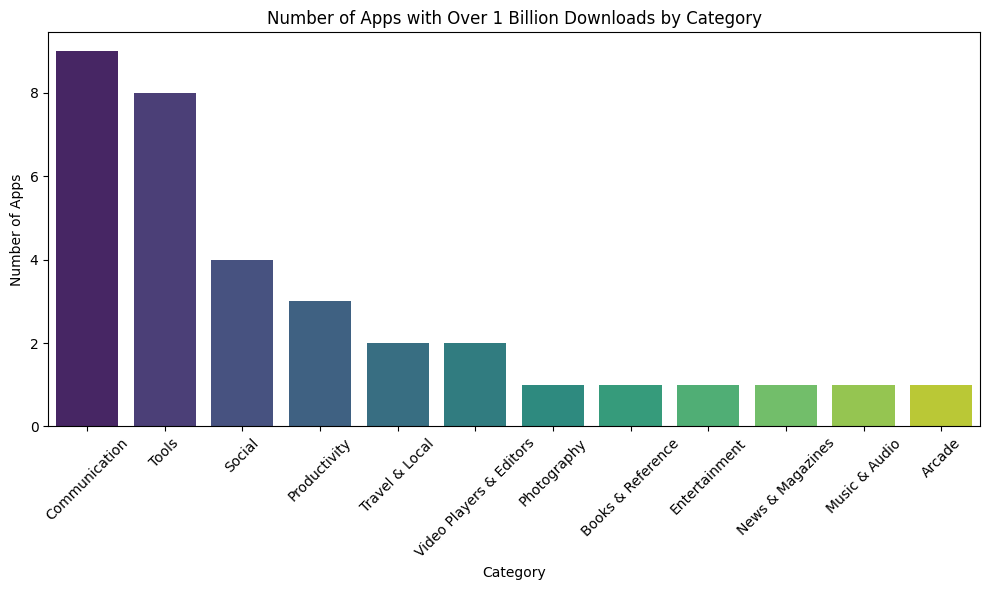

In [84]:
# Add '1B Downloads' column
downloads_across_level['1B Downloads'] = downloads_across_level['num_downloads'] >= 1_000_000_000

# Filter for apps with 1 billion or more downloads
billion_downloads = downloads_across_level[downloads_across_level['1B Downloads'] == True]

# Count the number of apps per category
billion_downloads_summary = billion_downloads['categ_app'].value_counts().reset_index()
billion_downloads_summary.columns = ['Category', 'Number of Apps']

# Visualize the data
plt.figure(figsize=(10, 6))
sns.barplot(data=billion_downloads_summary, x='Category', y='Number of Apps', palette='viridis')
plt.title('Number of Apps with Over 1 Billion Downloads by Category')
plt.xlabel('Category')
plt.ylabel('Number of Apps')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



C:\Users\Kevin\AppData\Local\Temp\ipykernel_20008\456726481.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = downloads_across_level.groupby(['level', 'downloads_bin']).size().unstack(fill_value=0)


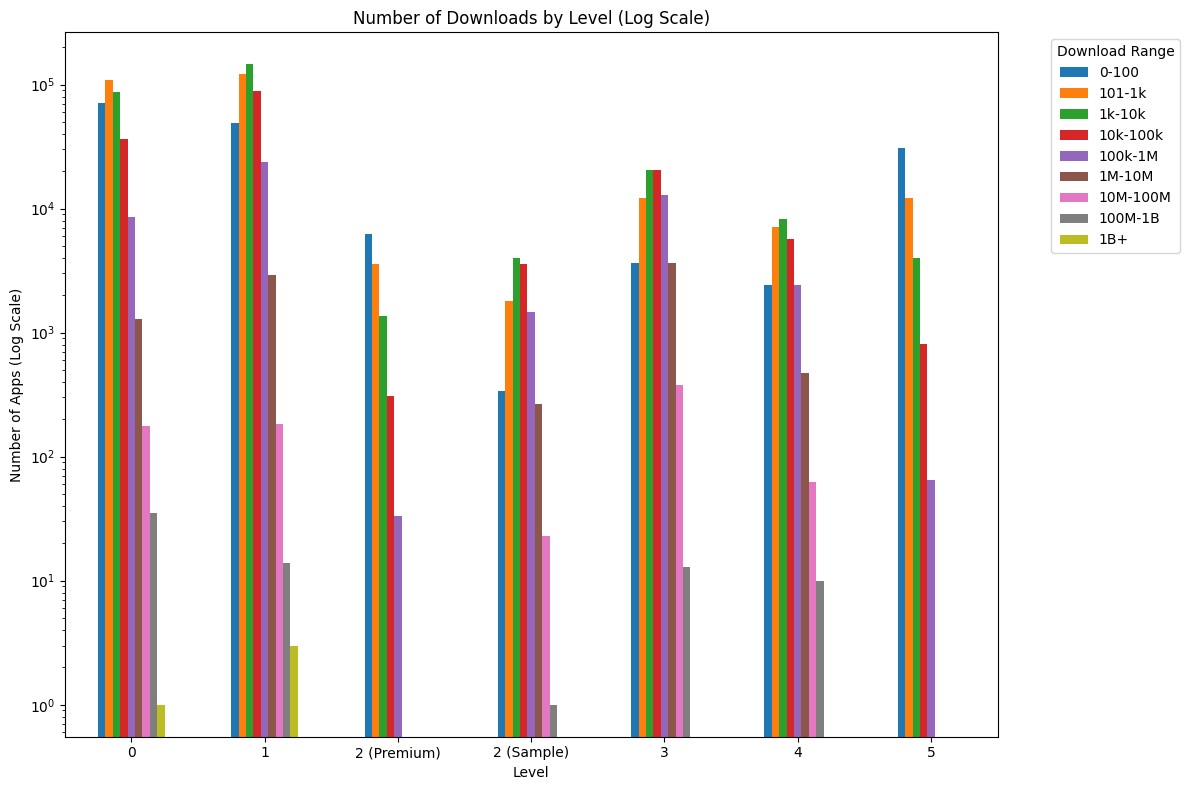

In [85]:
# Define the bins and labels
bins = [0, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, np.inf]
labels = ['0-100', '101-1k', '1k-10k', '10k-100k', '100k-1M', '1M-10M', '10M-100M', '100M-1B', '1B+']

# Create a new column 'downloads_bin' based on the number of downloads
downloads_across_level['downloads_bin'] = pd.cut(downloads_across_level['num_downloads'], bins=bins, labels=labels)

# Group by 'level' and 'downloads_bin' to get the count of apps per download bin for each level
grouped = downloads_across_level.groupby(['level', 'downloads_bin']).size().unstack(fill_value=0)

# Plotting the bar chart with log scale
ax = grouped.plot(kind='bar', stacked=False, figsize=(12, 8), logy=True)
ax.set_title('Number of Downloads by Level (Log Scale)')
ax.set_xlabel('Level')
ax.set_ylabel('Number of Apps (Log Scale)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.legend(title='Download Range', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

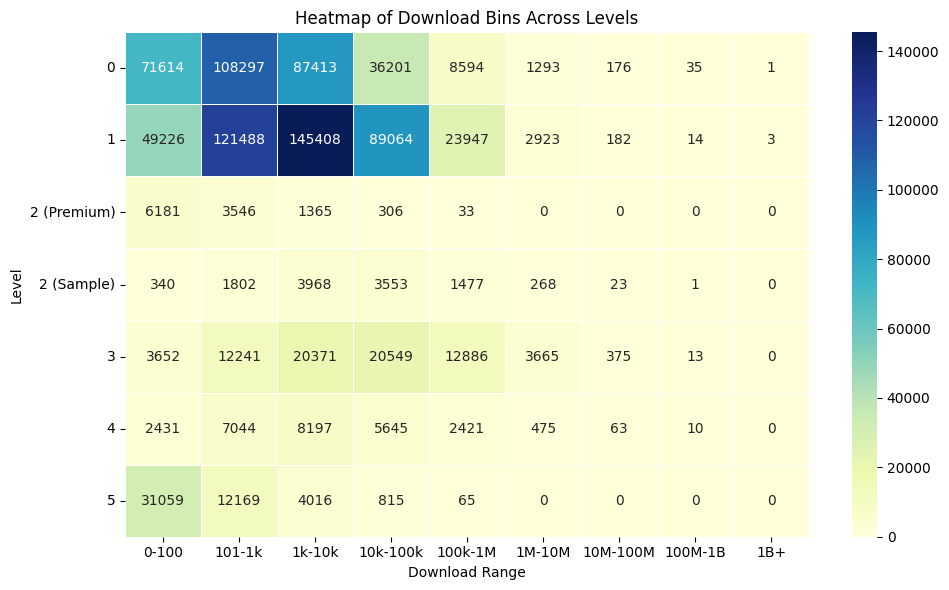

In [86]:
plt.figure(figsize=(10, 6))
sns.heatmap(grouped, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap of Download Bins Across Levels')
plt.xlabel('Download Range')
plt.ylabel('Level')
plt.tight_layout()

plt.show()


#### 3.1.5.2 Paid vs Free Version

In [87]:
paid_free_version = df_level_combined.copy()

# if level is 0 or 1 then new column category is 'Free apps'
paid_free_version['category'] = ['Free' if level in ['0', '1', '2 (Sample)', '3', '4'] else 'Paid' for level in paid_free_version['level']]

In [88]:
# relevant columns
relevant_columns_paid_free_version = ['num_downloads', 'category']

# filter the relevant columns
paid_free_version = paid_free_version[relevant_columns_paid_free_version]

In [89]:
paid_free_version.head()

,num_downloads,category
14,50000,Free
24,5000,Free
25,500000,Free
26,100,Free
28,500,Free


In [90]:
# Calculate the sum of downloads for each category
total_downloads_paid_free_version = paid_free_version.groupby('category')['num_downloads'].sum().reset_index()

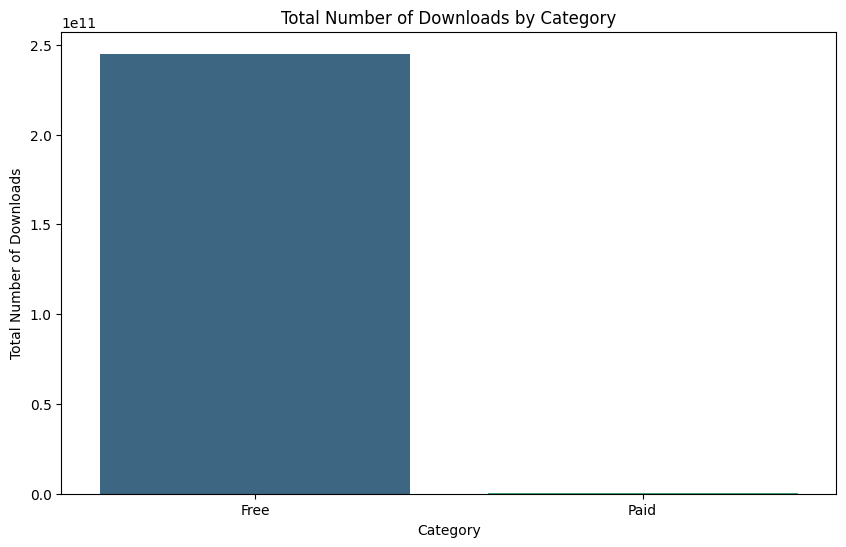

In [91]:
# Plot the total number of downloads by category
plt.figure(figsize=(10, 6))
sns.barplot(data=total_downloads_paid_free_version, x='category', y='num_downloads', hue='category', palette='viridis', dodge=False)
plt.title('Total Number of Downloads by Category')
plt.xlabel('Category')
plt.ylabel('Total Number of Downloads')
plt.show()

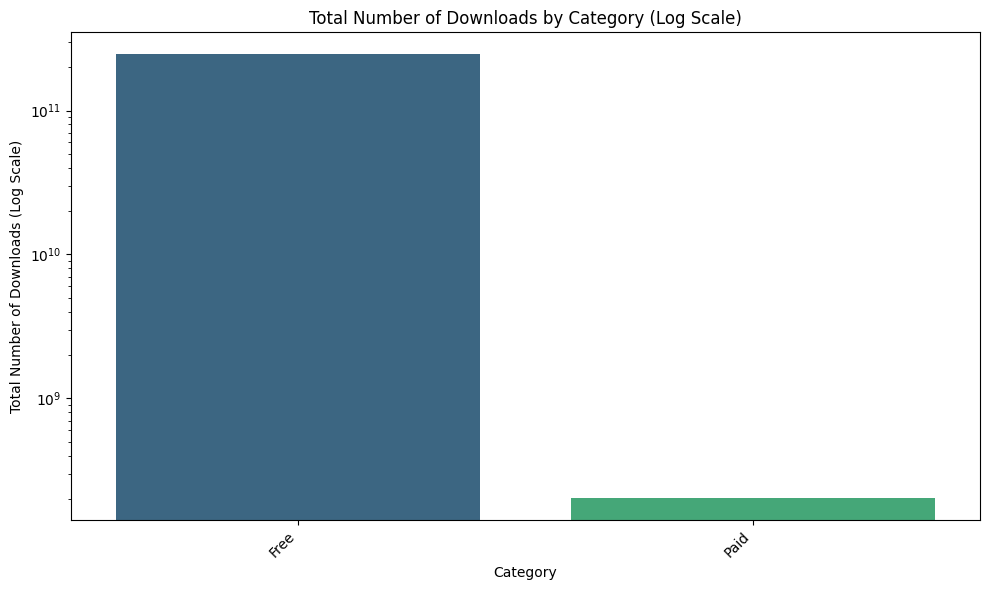

In [92]:
# Plot the total number of downloads by category with a logarithmic scale
plt.figure(figsize=(10, 6))
sns.barplot(data=total_downloads_paid_free_version, x='category', y='num_downloads', hue='category', palette='viridis', dodge=False)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Total Number of Downloads by Category (Log Scale)')
plt.xlabel('Category')
plt.ylabel('Total Number of Downloads (Log Scale)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility if needed
plt.tight_layout()
plt.show()


#### 3.1.5.3 Gaming

In [93]:
all_apps = df_level_combined.copy()

# Filter other than gaming apps
other_apps = all_apps[~all_apps['categ_app'].isin(gaming_categories)]

gaming_apps = df_level_combined_h1d.copy()

In [94]:
# relevant columns
relevant_columns_other_apps = ['my_app_id', 'num_downloads', 'level', 'categ_app']

# filter the relevant columns
other_apps = other_apps[relevant_columns_other_apps]

In [95]:
gaming_apps.head()

,my_app_id,num_downloads,level,categ_app
28,AndroidRoll.Roll,500,0,Casual
89,Discworld.Quiz,5000,0,Puzzle
111,ForgottenTales.PetrifiedSandworm,1000,0,Adventure
187,LiborVasa.Ships,500000,0,Brain Games
190,LuckyPangPang.app,1000,0,Arcade


In [96]:
other_apps.head()

,my_app_id,num_downloads,level,categ_app
14,Alfasoft.Widgets.PsychedelicAnalogClock,50000,0,Personalization
24,AmaxSoftware.bubblelevel,5000,0,Tools
25,Andrew.Compass.com,500000,0,Tools
26,Android.Page,100,0,Libraries & Demo
30,Animato.Paev,50000,0,Books & Reference


In [97]:
# Calculate the sum of downloads for each category
total_downloads_gaming_apps = gaming_apps['num_downloads'].sum()
total_downloads_other_apps = other_apps['num_downloads'].sum()
avg_downloads_gaming_apps = gaming_apps['num_downloads'].mean()
avg_downloads_other_apps = other_apps['num_downloads'].mean()
total_amount_gaming_apps = len(gaming_apps)
total_amount_other_apps = len(other_apps)

# Creating a new dataframe to represent the totals
summary_data = {
    "Category": ["Gaming Apps", "Other Apps"],
    "Total Downloads": [total_downloads_gaming_apps, total_downloads_other_apps],
    "Total Amount": [total_amount_gaming_apps, total_amount_other_apps],
    "Average Downloads": [avg_downloads_gaming_apps, avg_downloads_other_apps]

}
df_summary = pd.DataFrame(summary_data)

df_summary.head()

,Category,Total Downloads,Total Amount,Average Downloads
0,Gaming Apps,65397548186,141913,460828.452545
1,Other Apps,179836749122,775023,232040.531858


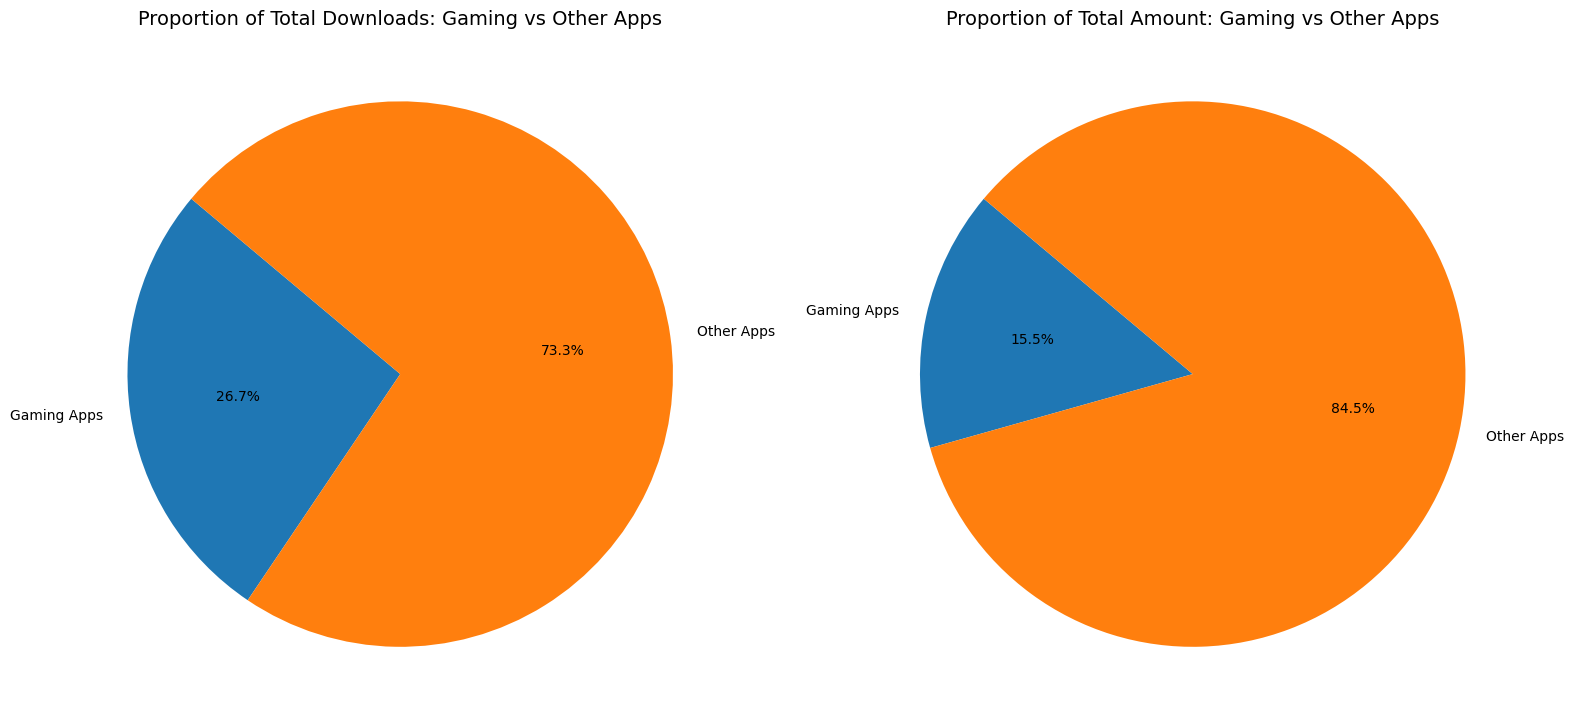

In [98]:
# Creating pie charts next to each other
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Pie chart for Total Downloads
axs[0].pie(df_summary['Total Downloads'], labels=df_summary['Category'], autopct='%1.1f%%', startangle=140)
axs[0].set_title('Proportion of Total Downloads: Gaming vs Other Apps', fontsize=14)

# Pie chart for Total Amount
axs[1].pie(df_summary['Total Amount'], labels=df_summary['Category'], autopct='%1.1f%%', startangle=140)
axs[1].set_title('Proportion of Total Amount: Gaming vs Other Apps', fontsize=14)

# Display the pie charts
plt.tight_layout()
plt.show()

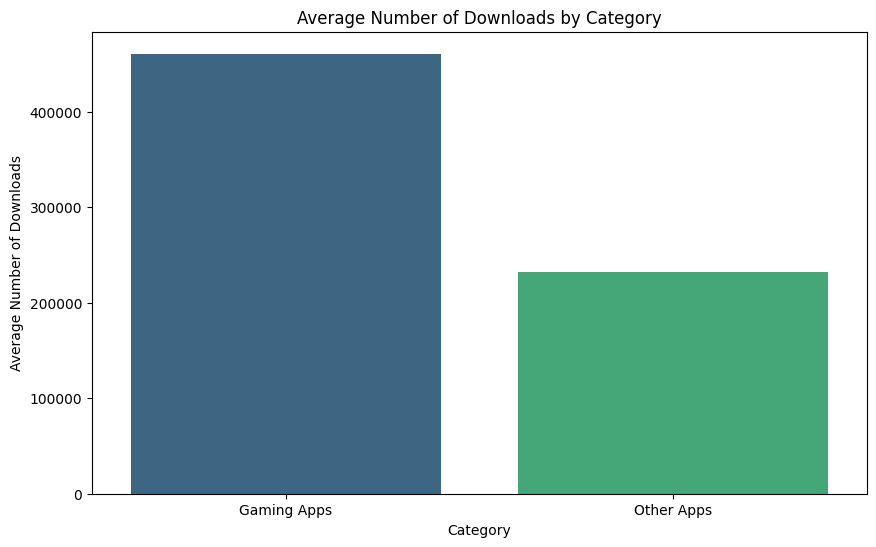

In [99]:
# Plot the average number of downloads by category
plt.figure(figsize=(10, 6))
sns.barplot(data=df_summary, x='Category', y='Average Downloads', hue='Category', palette='viridis', dodge=False)
plt.title('Average Number of Downloads by Category')
plt.xlabel('Category')
plt.ylabel('Average Number of Downloads')
plt.show()

In [100]:
# Combine both datasets
all_apps = pd.concat([gaming_apps, other_apps])

# Calculate averages
gaming_avg = gaming_apps['num_downloads'].mean()
other_avg = other_apps['num_downloads'].mean()
overall_avg = all_apps['num_downloads'].mean()

# Percentage difference between gaming apps and overall average
gaming_vs_baseline_difference = ((gaming_avg - overall_avg) / overall_avg) * 100

# Percentage difference between other apps and overall average
other_vs_baseline_difference = ((other_avg - overall_avg) / overall_avg) * 100

# Percentage difference between gaming apps and other apps
gaming_vs_other_difference = ((gaming_avg - other_avg) / other_avg) * 100

# Create a summary table with shorter column names
summary_table = pd.DataFrame({
    'Category': ['Gaming', 'Other', 'Baseline'],
    'Avg Downloads': [gaming_avg, other_avg, overall_avg],
    '% Diff vs Baseline': [
        gaming_vs_baseline_difference, 
        other_vs_baseline_difference, 
        0  # Baseline itself, so difference is 0%
    ],
    '% Diff Gaming vs Other': [
        gaming_vs_other_difference, 
        gaming_vs_other_difference * -1, 
        None  # No comparison for the baseline
    ]
})

# Round the values for better readability
summary_table = summary_table.round(2)

summary_table

,Category,Avg Downloads,% Diff vs Baseline,% Diff Gaming vs Other
0,Gaming,460828.45,72.30,98.6
1,Other,232040.53,-13.24,-98.6
2,Baseline,267449.74,0.00,NaN


## 3.2 Rating

The downloads of an app are not everything. An app can be downloaded often, but may not
be highly rated.
* H2a: Apps that require the user to pay to unlock features (level 2, 3, and 4) will tend to have lower ratings than the version that requires payment upfront (level 5). The main draw of a freemium model is to attract users, and have them update to a paid version (Kumar 2014). However, as Kumar (2014) points out, this can be a double-edged sword. Too few features, and it may not be attractive to users. Too many features, and the users will not update.

* H2b: Fully premium apps (level 5) will have less variance in their ratings, while all other
levels will have more. In the same vein as H2a, users have more realistic expectations of
paid apps compared to apps that require you to unlock features (Kumar 2014). Therefore, more users downloading premium apps will be satisfied with their purchase, leading to less variance.

* H3: For apps that utilize a sample and a premium version of the same app (level 2), the rating of the paid-for version is positively associated with the rating of the free version of the same app. This was true for the study on the most popular apps in the Google Play Store by Liu, Au, and Choi (2012), so it is expected a similar pattern should arise for this dataset.

### 3.2.1 H2a

In [101]:
df_level_combined_h2a = df_level_combined.copy()

# Filter only levels 2, 3, 4, and 5
df_h2a = df_level_combined_h2a[df_level_combined_h2a['level'].isin(['2 (Sample)', '2 (Premium)', '3', '4', '5'])].copy()

# Filter on premium and free apps
df_h2a['category'] = np.where((df_h2a['level'] == '5') | (df_h2a['level'] == '2 (Premium)'), 'Premium apps', 'Free apps')

In [102]:
# relevant columns
relevant_columns_h2a = ['category', 'rating_app', 'bayesian_average']

# filter the relevant columns
df_h2a = df_h2a[relevant_columns_h2a]

In [103]:
df_h2a.head()

,category,rating_app,bayesian_average
130,Free apps,4.4,4.377555
132,Free apps,3.9,3.92358
142,Free apps,4.3,4.295344
156,Free apps,3.9,3.940634
159,Free apps,2.5,3.915941


#### 3.2.1.1 Apps that require the user to pay to unlock features (level 2, 3, and 4) will tend to have lower ratings than the version that requires payment upfront (level 5).

In [104]:
# Calculating the mean rating for Free and Premium apps
mean_rating_free = df_h2a[df_h2a['category'] == 'Free apps']['rating_app'].mean()
mean_rating_premium = df_h2a[df_h2a['category'] == 'Premium apps']['rating_app'].mean()

# Calculating the mean Bayesian average for Free and Premium apps
mean_bayesian_free = df_h2a[df_h2a['category'] == 'Free apps']['bayesian_average'].mean()
mean_bayesian_premium = df_h2a[df_h2a['category'] == 'Premium apps']['bayesian_average'].mean()

# Creating a new DataFrame from these results
mean_results = pd.DataFrame({
    'Category': ['Free apps', 'Premium apps'],
    'Mean Rating': [mean_rating_free, mean_rating_premium],
    'Mean Bayesian Average': [mean_bayesian_free, mean_bayesian_premium]
})

C:\Users\Kevin\AppData\Local\Temp\ipykernel_20008\1975897761.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ratings_data, labels=categories, patch_artist=True)


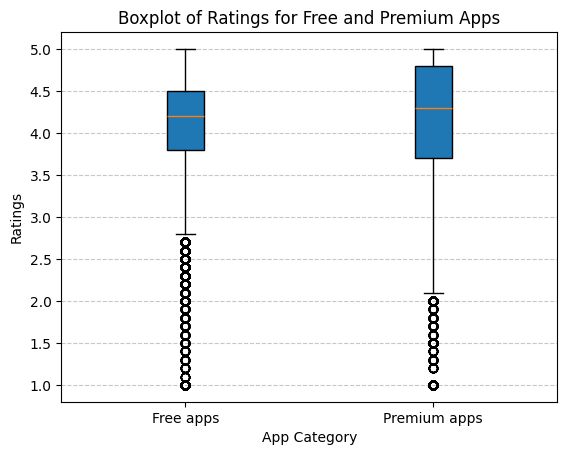

In [136]:
# Combine ratings for boxplot
categories = ['Free apps', 'Premium apps']
ratings_data = [df_h2a[df_h2a['category'] == cat]['rating_app'] for cat in categories]

plt.boxplot(ratings_data, labels=categories, patch_artist=True)
plt.title('Boxplot of Ratings for Free and Premium Apps')
plt.ylabel('Ratings')
plt.xlabel('App Category')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [105]:
mean_results

,Category,Mean Rating,Mean Bayesian Average
0,Free apps,4.082801,4.118043
1,Premium apps,4.084874,4.110071


#### 3.1.3.2 Too few features, and it may not be attractive to users. Too many features, and the users will not update.

In [106]:
### NOT POSSIBLE WITH DATASET

### 3.2.2 H2b

In [107]:
df_level_combined_h2b = df_level_combined.copy()

# Filter on level 5 and others
df_level_combined_h2b['category'] = np.where(df_level_combined_h2b['level'] == '5', 'Premium apps', 'Other apps')

In [108]:
# relevant columns
relevant_columns_h2b = ['category', 'rating_app', 'bayesian_average']

# filter the relevant columns
df_level_combined_h2b = df_level_combined_h2b[relevant_columns_h2b]

In [109]:
df_level_combined_h2b.head()

,category,rating_app,bayesian_average
14,Other apps,3.9,3.918767
24,Other apps,3.9,4.026743
25,Other apps,3.7,3.710579
26,Other apps,4.0,4.070666
28,Other apps,4.4,4.180342


#### 3.2.2.1 Fully premium apps (level 5) will have less variance in their ratings, while all other levels will have more.

In [110]:
# Average rating for Premium and Other apps
average_rating_premium_h2b = df_level_combined_h2b[df_level_combined_h2b['category'] == 'Premium apps']['rating_app'].mean()
average_rating_other_h2b = df_level_combined_h2b[df_level_combined_h2b['category'] == 'Other apps']['rating_app'].mean()

print(f"Average rating for Premium apps: {average_rating_premium_h2b}")
print(f"Average rating for Other apps: {average_rating_other_h2b}")

Average rating for Premium apps: 4.059768156888816
Average rating for Other apps: 4.101814917127072


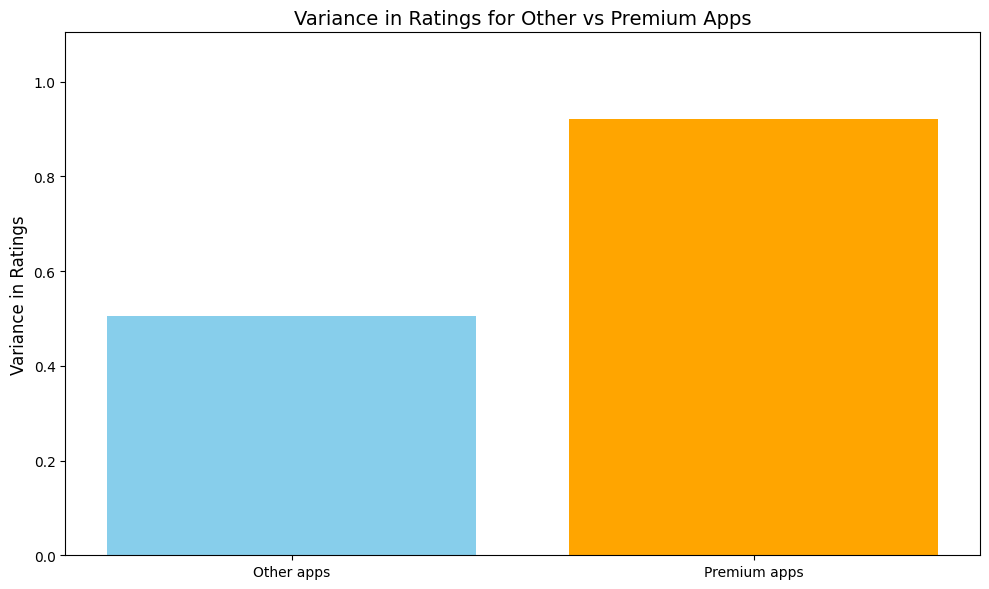

In [111]:
# Filtering data for Free and Premium apps
other_apps = df_level_combined_h2b[df_level_combined_h2b['category'] == 'Other apps']
premium_apps = df_level_combined_h2b[df_level_combined_h2b['category'] == 'Premium apps']

# Calculating variances for ratings and bayesian averages
other_variance_rating = other_apps['rating_app'].var()
premium_variance_rating = premium_apps['rating_app'].var()

# Creating a bar plot for variances in ratings
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(['Other apps', 'Premium apps'], [other_variance_rating, premium_variance_rating], color=['skyblue', 'orange'])
ax.set_ylabel('Variance in Ratings', fontsize=12)
ax.set_title('Variance in Ratings for Other vs Premium Apps', fontsize=14)
ax.set_ylim(0, max(other_variance_rating, premium_variance_rating) * 1.2)

plt.tight_layout()
plt.show()

### 3.2.3 H3

In [112]:
df_sample_h3 = df_level_2_sample.copy()
df_premium_h3 = df_level_2_premium.copy()
df_mapping_h3 = df_similarities.copy()

In [113]:
# relevant columns
relevant_columns_h3 = ['my_app_id', 'level', 'rating_app', 'bayesian_average']
relevant_columns_mapping_h3 =  ['Sample app name',	'Premium app name']

# filter the relevant columns
df_sample_h3 = df_sample_h3[relevant_columns_h3]
df_premium_h3 = df_premium_h3[relevant_columns_h3]
df_mapping_h3 = df_mapping_h3[relevant_columns_mapping_h3]


In [114]:
# Merge mapping dataframe with sample dataframe and premium dataframe
df_mapped_h3 = (
    df_mapping_h3
    .merge(df_sample_h3[['my_app_id', 'bayesian_average', 'rating_app']], left_on='Sample app name', right_on='my_app_id', how='left')
    .drop(columns=['my_app_id'])
    .rename(columns={'num_downloads': 'Sample Downloads', 'rating_app': 'Sample Rating', 'bayesian_average': 'Sample Bayesian Average'})
    .merge(df_premium_h3[['my_app_id', 'bayesian_average', 'rating_app']], left_on='Premium app name', right_on='my_app_id', how='left')
    .drop(columns=['my_app_id'])
    .rename(columns={'num_downloads': 'Premium Downloads', 'rating_app': 'Premium Rating', 'bayesian_average': 'Premium Bayesian Average'})
)

In [115]:
df_mapped_h3.head()

,Sample app name,Premium app name,Sample Bayesian Average,Sample Rating,Premium Bayesian Average,Premium Rating
0,HBSpritverbrauch.lite,HBSpritverbrauch.full,4.377555,4.4,4.574476,4.6
1,HBVerbrauchszaehler.lite,HBVerbrauchszaehler.full,3.92358,3.9,4.576525,4.6
2,Hurricane.Software,Hurricane.Software.Pro,4.295344,4.3,4.063529,4.0
3,JVC.FOViewerDX,JVC.FOViewerDXFull,3.940634,3.9,4.159597,4.1
4,JVC.FOViewerDXHDTrial,JVC.FOViewerDXHD,3.915941,2.5,4.161655,3.8


#### 3.2.3.1 For apps that utilize a sample and a premium version of the same app (level 2), the rating of the paid-for version is positively associated with the rating of the free version of the same app.

In [ ]:
# Correlation Coefficient
correlation_rating_h3 = df_mapped_h3["Sample Rating"].corr(df_mapped_h3["Premium Rating"])

# Correlation Coefficient for Bayesian averages
correlation_bayesian_rating_h3 = df_mapped_h3["Sample Bayesian Average"].corr(df_mapped_h3["Premium Bayesian Average"])

In [117]:
correlation_data_h3 = {
    "Metric": ["Sample Rating vs Premium Rating", "Sample Bayesian Average vs Premium Bayesian Average"],
    "Correlation Coefficient": [correlation_rating_h3, correlation_bayesian_rating_h3]
}
pd.DataFrame(correlation_data_h3)

,Metric,Correlation Coefficient
0,Sample Rating vs Premium Rating,0.352868
1,Sample Bayesian Average vs Premium Bayesian Av...,0.505431


### 3.2.4 Other Results

#### 3.2.4.1 Across Levels

In [118]:
ratings_across_level = df_level_combined.copy()

In [119]:
# Group by 'level' and calculate mean for 'rating_app' and 'bayesian_average'
average_ratings = ratings_across_level.groupby('level')['rating_app'].mean()
bayesian_ratings = ratings_across_level.groupby('level')['bayesian_average'].mean()

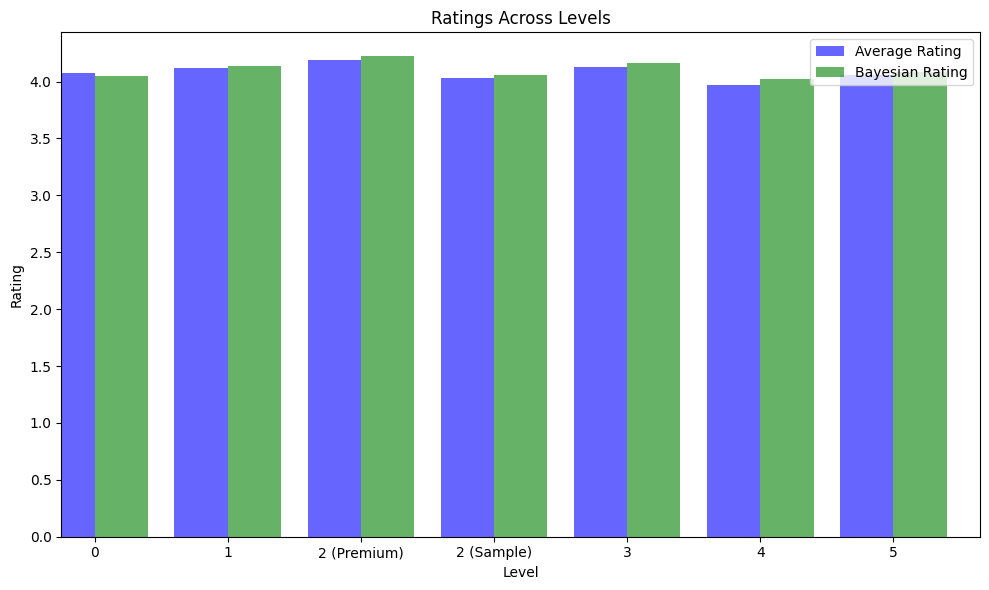

In [120]:
# Plotting the ratings across levels
plt.figure(figsize=(10, 6))

# Bar plot for ratings and Bayesian ratings
average_ratings.plot(kind='bar', width=0.4, position=1, label='Average Rating', color='blue', alpha=0.6)
bayesian_ratings.plot(kind='bar', width=0.4, position=0, label='Bayesian Rating', color='green', alpha=0.6)

# Adding labels and title
plt.xlabel('Level')
plt.ylabel('Rating')
plt.title('Ratings Across Levels')
plt.legend()
plt.xticks(rotation=0)

# Show plot
plt.tight_layout()
plt.show()

#### 3.2.4.2 Variance

In [121]:
variance_rating = df_level_combined.copy()

In [122]:
# Assuming your dataframe is named df
columns_to_calculate = ['rating_app', 'bayesian_average']
variance_specific = variance_rating.groupby('level')[columns_to_calculate].var().reset_index()

# Melting the dataframe to long format for easier plotting
variance_melted = variance_specific.melt(id_vars='level', var_name='Attribute', value_name='Variance')

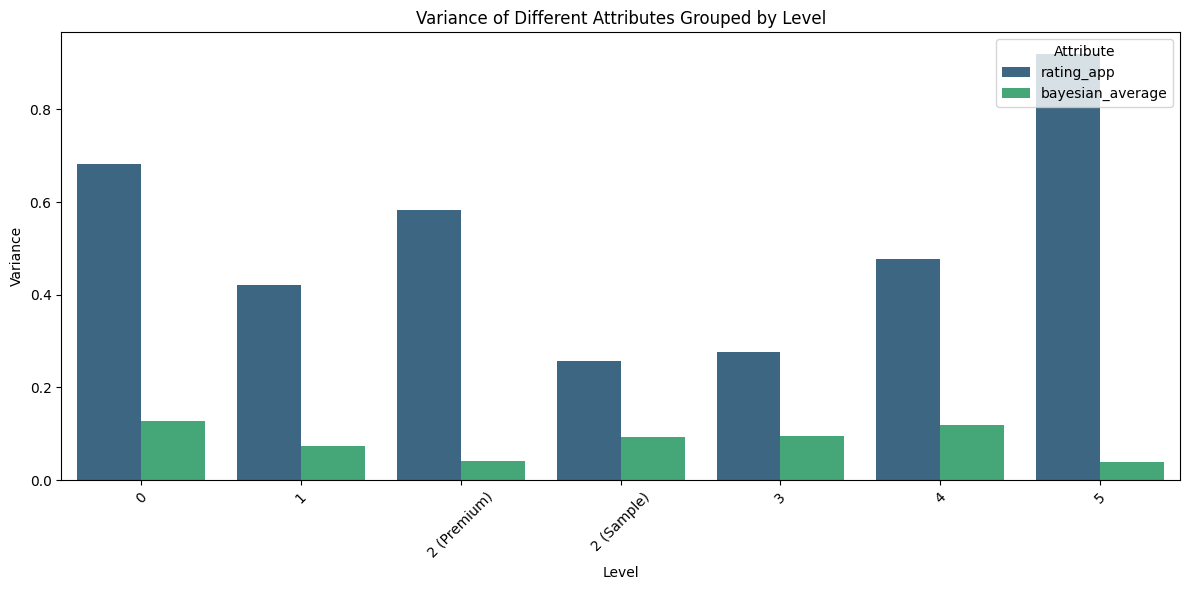

In [123]:
plt.figure(figsize=(12, 6))
sns.barplot(data=variance_melted, x='level', y='Variance', hue='Attribute', palette='viridis')
plt.title('Variance of Different Attributes Grouped by Level')
plt.xlabel('Level')
plt.ylabel('Variance')
plt.xticks(rotation=45)
plt.legend(title='Attribute', loc='upper right')
plt.tight_layout()
plt.show()

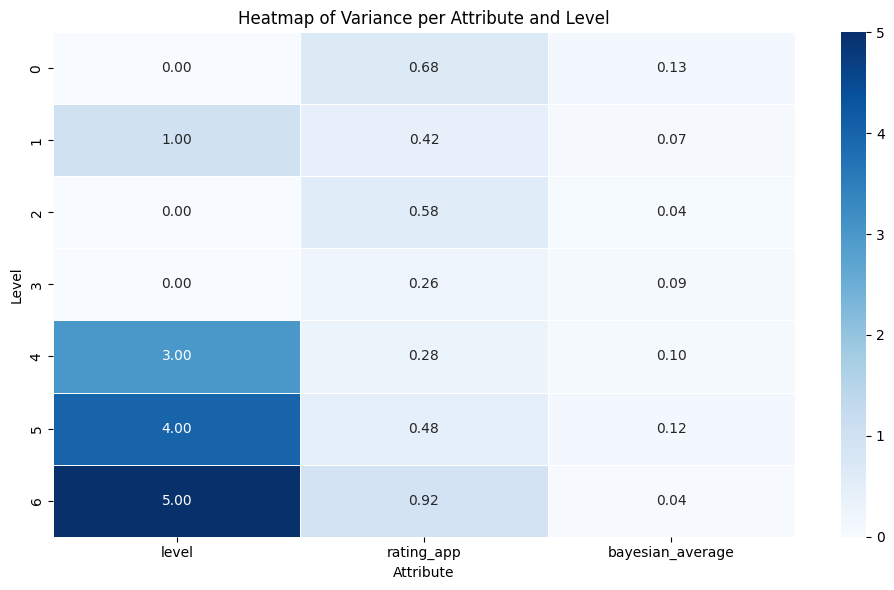

In [124]:
# Ensure data is numeric and check for NaN values
variance_per_level = variance_specific.apply(pd.to_numeric, errors='coerce')
variance_per_level = variance_per_level.fillna(0)  # Replace NaN with 0 for plotting

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(variance_per_level, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
plt.title('Heatmap of Variance per Attribute and Level')
plt.xlabel('Attribute')
plt.ylabel('Level')
plt.tight_layout()
plt.show()

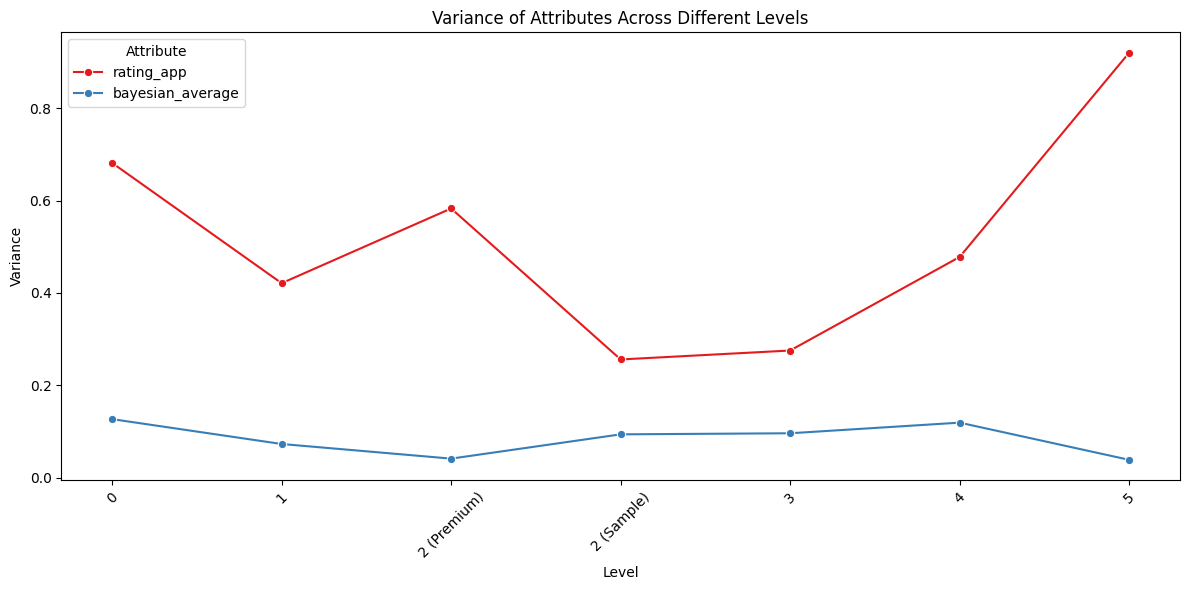

In [125]:
# Melting the dataframe to long format
variance_melted = variance_specific.melt(id_vars='level', var_name='Attribute', value_name='Variance')

# Plotting line plot with seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=variance_melted, x='level', y='Variance', hue='Attribute', marker='o', palette='Set1')
plt.title('Variance of Attributes Across Different Levels')
plt.xlabel('Level')
plt.ylabel('Variance')
plt.xticks(rotation=45)
plt.legend(title='Attribute')
plt.tight_layout()
plt.show()

#### 3.2.4.3 Paid vs Free Version

In [126]:
paid_free_version_rating = df_level_combined.copy()

# if level is 0 or 1 then new column category is 'Free apps'
paid_free_version_rating['category'] = ['Free' if level in ['0', '1', '2 (Sample)', '3', '4'] else 'Paid' for level in paid_free_version_rating['level']]

In [127]:
# relevant columns
relevant_columns_paid_free_version_rating = ['rating_app', 'bayesian_average', 'category']

# filter the relevant columns
paid_free_version_rating = paid_free_version_rating[relevant_columns_paid_free_version_rating]

In [128]:
paid_free_version_rating.head()

,rating_app,bayesian_average,category
14,3.9,3.918767,Free
24,3.9,4.026743,Free
25,3.7,3.710579,Free
26,4.0,4.070666,Free
28,4.4,4.180342,Free


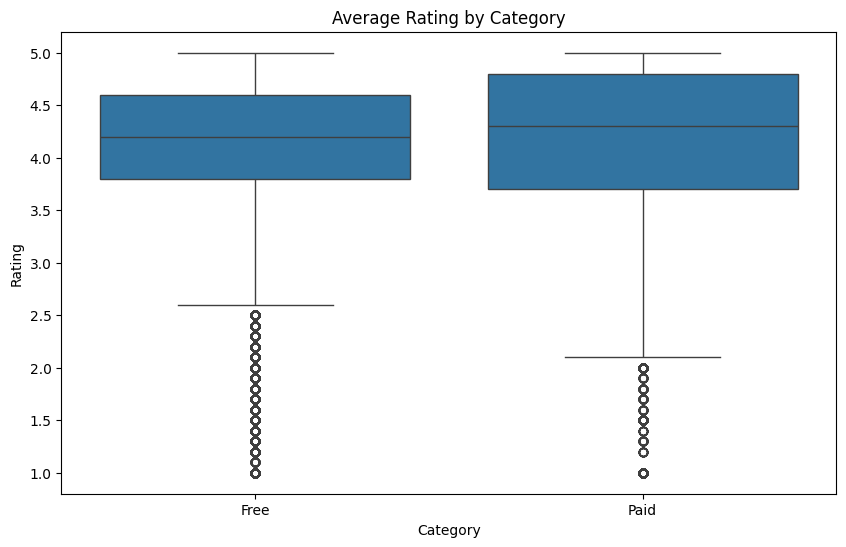

In [129]:
# Plot the average rating by category
plt.figure(figsize=(10, 6))
sns.boxplot(data=paid_free_version_rating, x='category', y='rating_app')
plt.title('Average Rating by Category')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.show()


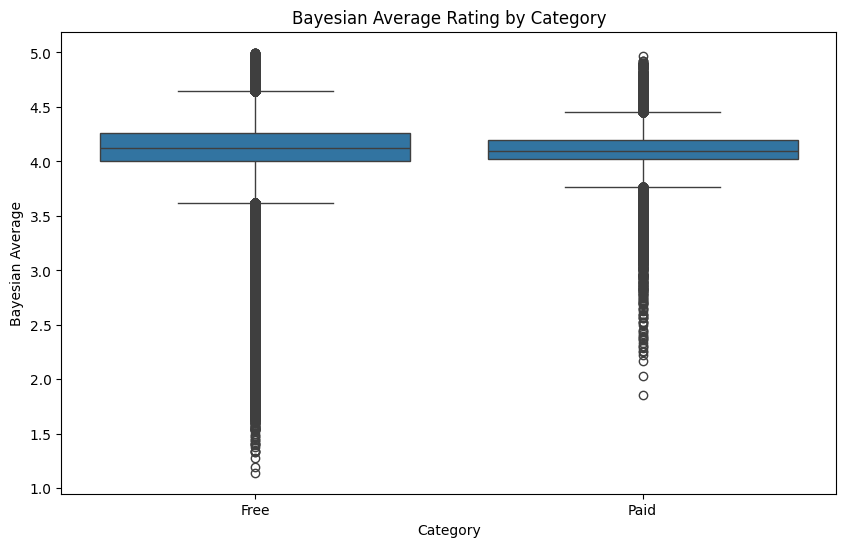

In [130]:
# Plot the bayesian average rating by category
plt.figure(figsize=(10, 6))
sns.boxplot(data=paid_free_version_rating, x='category', y='bayesian_average')
plt.title('Bayesian Average Rating by Category')
plt.xlabel('Category')
plt.ylabel('Bayesian Average')
plt.show()


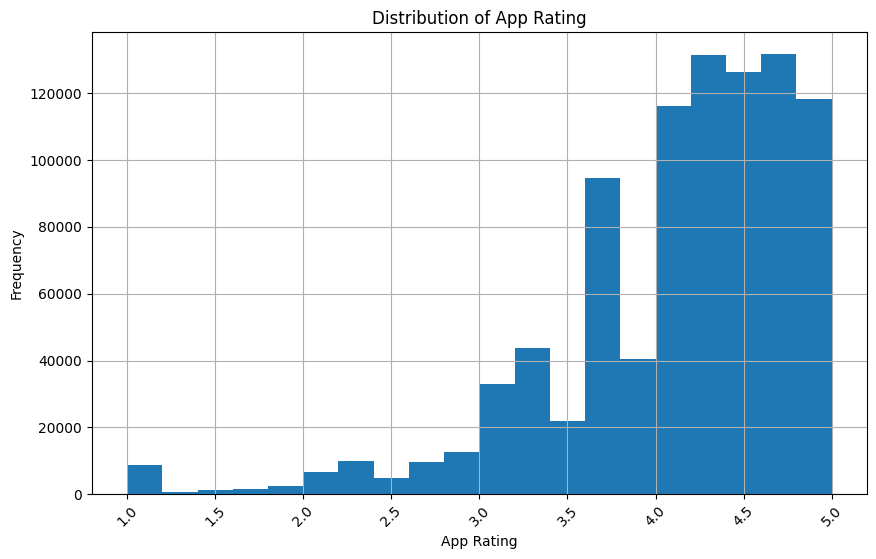

In [131]:
# Plot histogram
paid_free_version_rating['rating_app'].hist(bins=20, figsize=(10, 6))
plt.xlabel('App Rating')
plt.ylabel('Frequency')
plt.title('Distribution of App Rating')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

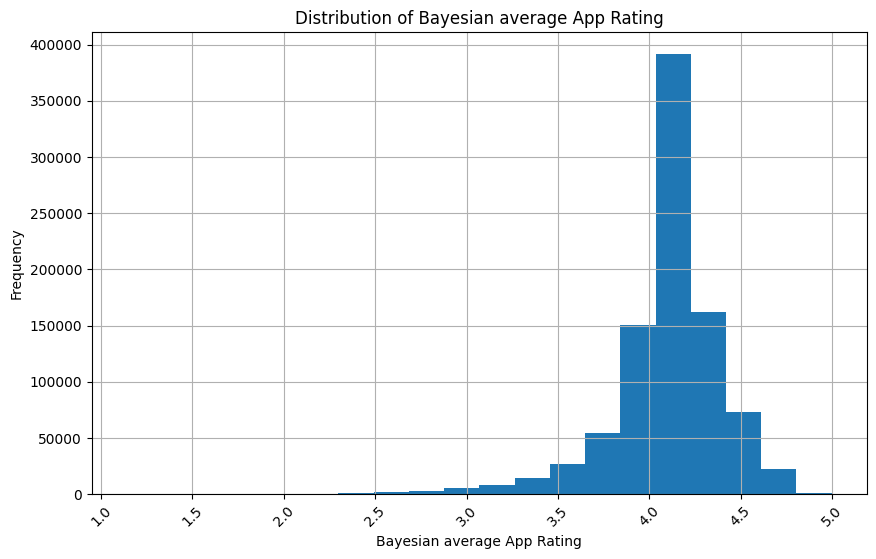

In [132]:
# Plot histogram
paid_free_version_rating['bayesian_average'].hist(bins=20, figsize=(10, 6))
plt.xlabel('Bayesian average App Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Bayesian average App Rating')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# 4. Other results

## 4.1 Content Ratings

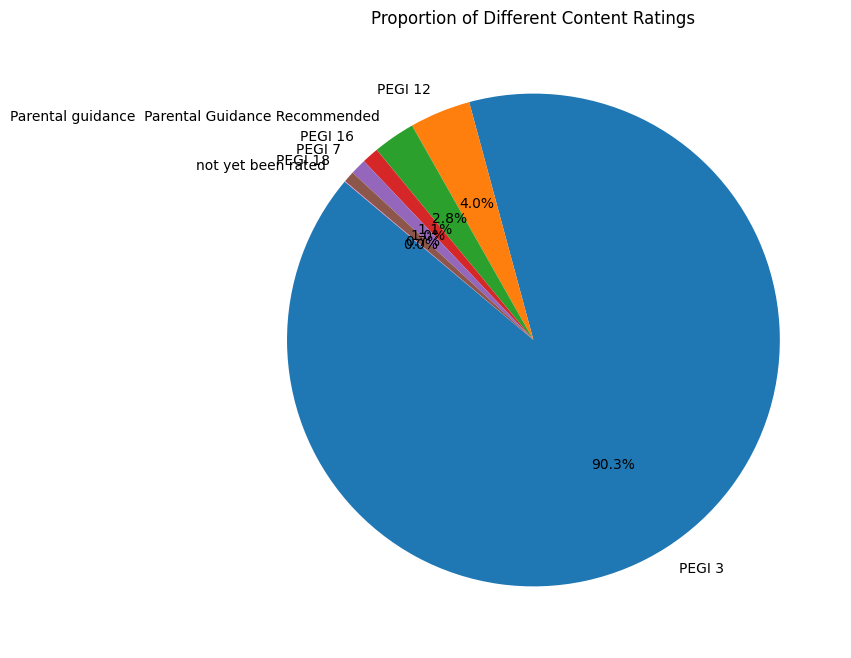

In [133]:
plt.figure(figsize=(8, 8))
content_rating_counts = df_filtered["content_rating_app"].value_counts(normalize=True) * 100  # percentage
content_rating_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Different Content Ratings")
plt.ylabel("")  # Hide y-axis label for cleaner look
plt.show()


## 4.2 Category of apps

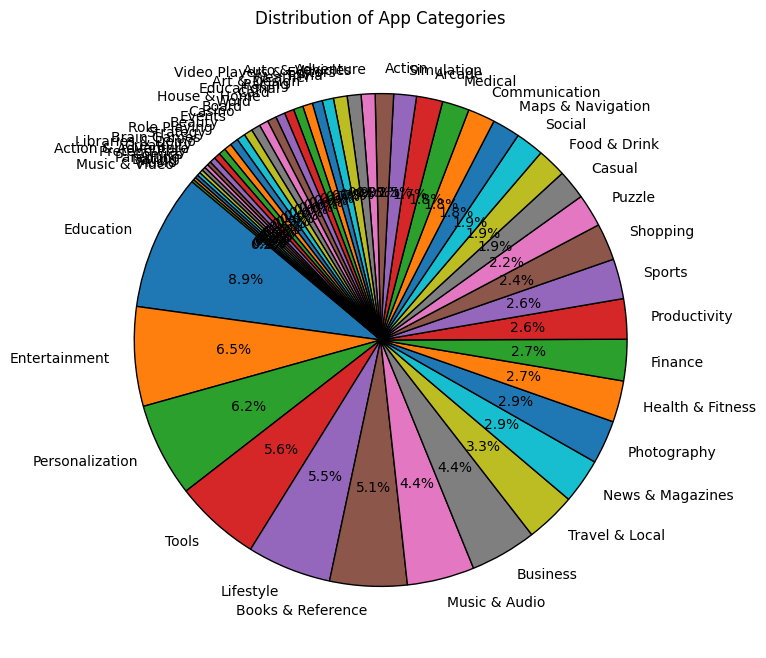

In [134]:
category_counts = df_filtered['categ_app'].value_counts()

plt.figure(figsize=(8, 8))

category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'})

plt.title("Distribution of App Categories")

plt.ylabel("")  # Hide y-axis label for cleaner look

plt.show()

## 4.3 Average app rating per category

<Figure size 1200x600 with 0 Axes>

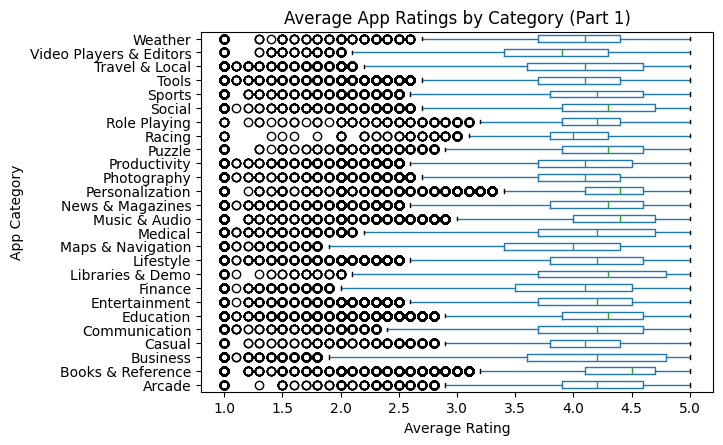

<Figure size 1200x600 with 0 Axes>

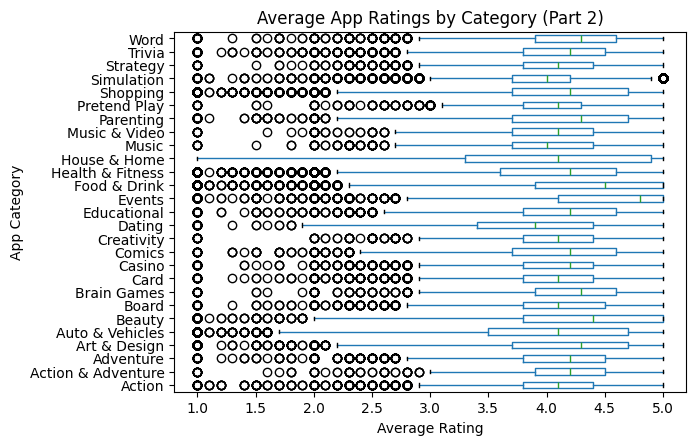

In [135]:
# Splitting categories into two parts for better readability
unique_categories = df_filtered["categ_app"].unique()
midpoint = len(unique_categories) // 2
categories_part1 = unique_categories[:midpoint]
categories_part2 = unique_categories[midpoint:]

# Filtering data for each part
df_category_part1 = df_filtered[df_filtered["categ_app"].isin(categories_part1)]
df_category_part2 = df_filtered[df_filtered["categ_app"].isin(categories_part2)]

# Plotting box plot for average app ratings by category (Part 1)
plt.figure(figsize=(12, 6))
df_category_part1.boxplot(column="rating_app", by="categ_app", grid=False, vert=False)
plt.title("Average App Ratings by Category (Part 1)")
plt.suptitle("")  # Remove default title to keep it clean
plt.xlabel("Average Rating")
plt.ylabel("App Category")
plt.show()

# Plotting box plot for average app ratings by category (Part 2)
plt.figure(figsize=(12, 6))
df_category_part2.boxplot(column="rating_app", by="categ_app", grid=False, vert=False)
plt.title("Average App Ratings by Category (Part 2)")
plt.suptitle("")  # Remove default title to keep it clean
plt.xlabel("Average Rating")
plt.ylabel("App Category")
plt.show()
